In [19]:
import numpy as np
from numpy.matlib import repmat
import scipy.stats
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from io import StringIO
from scipy import special
from scipy.optimize import minimize
from __future__ import division

class ExtData:
    def __init__(self):
        self.etaE = None
        self.etaI = None
        self.fE   = 0.0
        self.fI   = 0.0
        # ON-OFF visual pathway
        self.etaON  = None
        self.fON    = 0.0
        self.etaOFF = None
        self.fOFF   = 0.0

class StatData:
    def __init__(self):
        self.vbarE = None
        self.vbarI = None
        self.wbarE = None
        self.wbarI = None
        self.vbar3E = None
        self.vbar3I = None
        self.vbar4E = None
        self.vbar4I = None
        
        self.VEs    = None
        self.VIs    = None
        self.DE     = None
        self.DI     = None


class RecData:
    def __init__(self):
        self.mE = None
        self.mI = None
        self.SEE = 0.0
        self.SEI = 0.0
        self.SIE = 0.0
        self.SII = 0.0
        # LR connections
        self.LEE  = 0.0
        self.LIE  = 0.0
        self.LEEF = 0.0
        self.LIEF = 0.0
        
        self.In   = None
        
class NetParams:
    def __init__(self):
        self.NHYP = 0
        self.NE   = 0
        self.NI   = 0
        # SETTING
        self.gL   = 0.0
        self.vL   = 0.0
        self.V    = None
        self.h    = 0.0
        self.N_divide = 0
        self.dt = 0.0
        self.Final_time = 0.0
        self.tauN  = 0.0

        
def VQs(Ext,Rec,NetParams):
    # EXTRACT FR 
    (etaE,etaI,fE,fI,etaON,etaOFF,fON,fOFF) = (Ext.etaE,Ext.etaI,Ext.fE,Ext.fI,Ext.etaON,Ext.etaOFF,Ext.fON,Ext.fOFF)
    (mE,mI,In,SEE,SEI,SIE,SII,LEE,LIE,LEEF,LIEF) = (Rec.mE,Rec.mI,Rec.In,Rec.SEE,Rec.SEI,Rec.SIE,
                                                    Rec.SII,Rec.LEE,Rec.LIE,Rec.LEEF,Rec.LIEF)
    (vL,gL,dt,tauN,NHYP) = (NetParams.vL,NetParams.gL,NetParams.dt,NetParams.tauN,NetParams.NHYP)
    # CALCULATE $i_{NMDA}(lT+T)$
    INMDA = np.zeros_like(In)
    for i in range(NHYP):
        # Exc<-Exc
        INMDA[i,0] = np.sum(LEE*mE*(1-np.exp(-dt/tauN))) - LEE*mE[i,0]*(1-np.exp(-dt/tauN))
        INMDA[i,1] = np.sum(LIE*mE*(1-np.exp(-dt/tauN))) - LIE*mE[i,0]*(1-np.exp(-dt/tauN))
    In = In*np.exp(-dt/tauN) + INMDA
    """
    VEs = (vL*gL+etaE*fE+SEE*mE-SEI*mI)/gL  # DO NOT TAKE LR INTO CONSIDERATION
    VIs = (vL*gL+etaI*fI+SIE*mE-SII*mI)/gL
    """
    
    VEs = (vL*gL+etaE*fE+SEE*mE-SEI*mI+np.reshape(np.squeeze(In[:,0]),[NHYP,1]))/gL  # DO NOT TAKE LR INTO CONSIDERATION
    VIs = (vL*gL+etaI*fI+SIE*mE-SII*mI+np.reshape(np.squeeze(In[:,1]),[NHYP,1]))/gL 
    # print 'SHAPE VE: ',np.shape(VEs)
    # print 'SHAPE VI: ',np.shape(VIs)
    return (VEs,VIs,In)

def DQs(Ext,Rec,NetParams):
    # EXTRACT FR 
    (etaE,etaI,fE,fI,etaON,etaOFF,fON,fOFF) = (Ext.etaE,Ext.etaI,Ext.fE,Ext.fI,Ext.etaON,Ext.etaOFF,Ext.fON,Ext.fOFF)
    (mE,mI,In,SEE,SEI,SIE,SII,LEE,LIE,LEEF,LIEF) = (Rec.mE,Rec.mI,Rec.In,Rec.SEE,Rec.SEI,Rec.SIE,
                                                    Rec.SII,Rec.LEE,Rec.LIE,Rec.LEEF,Rec.LIEF)
    (vL,gL,dt,tauN,NE,NI) = (NetParams.vL,NetParams.gL,NetParams.dt,NetParams.tauN,NetParams.NE,NetParams.NI)
    # IGNORE $\sigma i_N$
    DE = (etaE*np.square(fE)+mE*np.square(SEE)/NE+mI*np.square(SEI)/NI)/gL
    DI = (etaI*np.square(fI)+mE*np.square(SIE)/NE+mI*np.square(SII)/NI)/gL
    return (DE,DI)

def rho_EQ(Vs,D,V):
    
    Rv = np.copy(V)
    (vT,vR) = (1.0,0.0)
    tmpg = np.greater(V,vR)
    indp = (np.where(tmpg))
    sqrtD  = np.sqrt(D)
    intovT  = special.dawsn((vT-Vs)/sqrtD)*np.exp(np.square(vT-Vs)/D)
    intovSD = special.dawsn(-Vs/sqrtD)*np.exp(np.square(Vs)/D)

    # compute R with V>vR case:
    # print 'shape 1: ',np.shape((V[indp])),np.shape(Vs),np.shape(special.dawsn((V[indp]-Vs)/sqrtD))
    # print 'shape 2: ',np.shape(np.exp(-np.square(V[indp]-Vs)/D))
    # print 'shape 3: ',np.shape(intovT)
    Rv[indp] = -special.dawsn((V[indp]-Vs)/sqrtD)+np.exp(-np.square(V[indp]-Vs)/D)*intovT
    if(indp[0][0]>1):
        Rv[0:indp[0][0]] = np.exp(-np.square(V[0:indp[0][0]]-Vs)/D)*(-intovSD + intovT)
    
    tmpl = np.less(V,-2.0/3.0)
    indp = np.where(tmpl)
    Rv[indp] = 0.0
    sum_c = (V[2]-V[1])*np.sum(Rv)
    # print 'sum_c',sum_c
    Rv = Rv/sum_c
    
    return (Rv,sum_c)

def solveVbarWbar4(NetParams,StatV,Rec):
    # EXTRACT STATE VARIABLES
    (dt,gL) = (NetParams.dt,NetParams.gL)
    (vbarE,wbarE,vbar3E,vbar4E) = (StatV.vbarE,StatV.wbarE,StatV.vbar3E,StatV.vbar4E)
    (vbarI,wbarI,vbar3I,vbar4I) = (StatV.vbarI,StatV.wbarI,StatV.vbar3I,StatV.vbar4I)
    (VEs,VIs,DE,DI) = (StatV.VEs,StatV.VIs,StatV.DE,StatV.DI)
    (mE,mI) = (Rec.mE,Rec.mI)
    # print 'mE,mI',mE,mI
    
    dtgL = dt*gL
    vbarE1 = vbarE + dtgL*(- mE/gL - (vbarE - VEs));
    vbarI1 = vbarI + dtgL*(- mI/gL - (vbarI - VIs));
    

    wbarE1 = wbarE + dtgL*(- mE/gL - 2.0*(wbarE - VEs*vbarE - 0.5*DE));
    wbarI1 = wbarI + dtgL*(- mI/gL - 2.0*(wbarI - VIs*vbarI - 0.5*DI));
    # print 'Wbar',wbarE,wbarI

    vbar3E1 = vbar3E + dtgL*(- mE/gL - 3.0*(vbar3E - VEs*wbarE - DE*vbarE));
    vbar3I1 = vbar3I + dtgL*(- mI/gL - 3.0*(vbar3I - VIs*wbarI - DI*vbarI));

    vbar4E1 = vbar4E + dtgL*(- mE/gL - 4.0*(vbar4E - VEs*vbar3E - 1.5*DE*wbarE));
    vbar4I1 = vbar4I + dtgL*(- mI/gL - 4.0*(vbar4I - VIs*vbar3I - 1.5*DI*wbarI));
    return (vbarE1,vbarI1,wbarE1,wbarI1,vbar3E1,vbar3I1,vbar4E1,vbar4I1)

def optfun(lambda_u,mu,x,Pq,fin,gamma):
    lambda_u = lambda_u[:]
    k  = np.size(mu)
    # mu = np.reshape(mu,[k,1])
    tt = np.zeros(k+1)
    tt[0] = 1
    tt[1:k+1]  = mu[:]
    # print 'mu: ',tt
    dx = x[1]-x[0]
    # print 'dx: ',dx,'lambda: ',lambda_u
    # print 'lambda: ', lambda_u
    # lambda_u = lambda0[:]
    N  =np.size(lambda_u)
    # print N,np.shape(fin)
    
    p  = Pq*np.exp(np.dot(fin[:,0:N],lambda_u))
    f  = dx*np.sum(p)-np.dot(np.reshape(tt,[1,k+1]),lambda_u)   
    # print 'f: ',f
    return f
 
def get_L_flow(NetParams,Rec,Vedges,Inmda):
    (gL,vL,N_divide,V,NHYP) = (NetParams.gL,NetParams.vL,NetParams.N_divide,NetParams.V,NetParams.NHYP)
    vT = 1.0
    tau_v = 1/gL
    (nbins,nbinp) = (N_divide-1,N_divide)
    vLn = vL  + Inmda/gL
    # vLn = vL # + Inmda/gL
    # SHAPE OF vLn is [NHYP,2(E/I)]
    L_flow = np.zeros([nbins,nbins])
    # common params
    dV = Net.h # 2.0/N_divide Net.h # dV = (vT-(vLn-vT))/nbins
    dt = Net.dt
    (edt,egt) = (np.exp(-dt/tau_v),np.exp(dt/tau_v))
    (row_ra,col_ra,val_ra) = ([],[],[])

    for j in range(nbins):
        Vpre = Vedges[j]*egt + vLn*(1-egt)
        Vpos = Vedges[j+1]*egt + vLn*(1-egt)
        # print Vpre,Vpos
        # Vbin [Vpre Vpos] means edges:
        jpre = (Vpre-(vL-vT))/dV + 1
        jpos = (Vpos-(vL-vT))/dV + 1
        # print jpre,jpos
        # integer
        jmin = np.floor(jpre)
        jmax = np.ceil(jpos)
        # print jmin,jmax
        # correspondig bin index
        bmin = jmin
        bmax = jmax - 1
        # print bmin,bmax
        # in order
        bvec = np.transpose(np.arange(bmin,(bmax+1)))
        # print bvec
        # distributed weight
        wmin = (jmin+1)-jpre
        wmax = jpos-(jmax-1)
        # print wmin,wmax
        wvec = np.ones([np.size(bvec),1])
        wvec[0,0]  = wmin
        wvec[-1,0] = wmax


        rvec = j*np.ones([np.size(bvec),1])
        # find effective
        tmp = (np.less_equal(bvec,nbins)&np.greater(bvec,0))
        vij = np.where(tmp)


        row_ra = np.append(row_ra,rvec[vij])        
        col_ra = np.append(col_ra,bvec[vij])
        val_ra = np.append(val_ra,wvec[vij])

    row_ra = row_ra.flatten()
    col_ra = col_ra.flatten()
    val_ra = val_ra.flatten()
    # print col_ra[-1],nbins
    L_flow = sparse.coo_matrix((val_ra,(row_ra,col_ra)),shape=(nbins+1,nbins+1))
    L_flow = L_flow.toarray()
    return L_flow

def get_L_kick(NetParams,Rec,Vedges,kick_val):
    (gL,vL,N_divide,V,NHYP) = (NetParams.gL,NetParams.vL,NetParams.N_divide,NetParams.V,NetParams.NHYP)
    vT = 1.0
    tau_v = 1/gL
    (nbins,nbinp) = (N_divide-1,N_divide)
    vLn = vL  + Inmda/gL
    # vLn = vL # + Inmda/gL
    # SHAPE OF vLn is [NHYP,2(E/I)]
    L_flow = np.zeros([nbins,nbins])
    # common params
    dV = Net.h # 2.0/N_divide Net.h # dV = (vT-(vLn-vT))/nbins
    dt = Net.dt
    (edt,egt) = (np.exp(-dt/tau_v),np.exp(dt/tau_v))
    (row_ra,col_ra,val_ra) = ([],[],[])

    for j in range(nbins):
        Vpre = Vedges[j]-kick_val
        Vpos = Vedges[j+1]-kick_val
        # print Vpre,Vpos
        # Vbin [Vpre Vpos] means edges:
        jpre = (Vpre-(vL-vT))/dV + 1
        jpos = (Vpos-(vL-vT))/dV + 1
        # print jpre,jpos
        # integer
        jmin = np.floor(jpre)
        jmax = np.ceil(jpos)
        # print jmin,jmax
        # correspondig bin index
        bmin = jmin
        bmax = jmax - 1
        # print bmin,bmax
        # in order
        bvec = np.transpose(np.arange(bmin,(bmax+1)))
        # print bvec
        # distributed weight
        if (np.size(bvec)>1):
            wmin = (jmin+1)-jpre
            wmax = jpos-(jmax-1)
            # print wmin,wmax
            wvec = np.ones([np.size(bvec),1])
            wvec[0,0]  = wmin
            wvec[-1,0] = wmax
            rvec = j*np.ones([np.size(bvec),1])
        else if(np.size(bvec)==1):
            wvec = np.ones([1,1])
            rvec = j*np.ones([np.size(bvec),1])
        # find effective
        tmp = (np.less_equal(bvec,nbins)&np.greater(bvec,0))
        vij = np.where(tmp)


        row_ra = np.append(row_ra,rvec[vij])        
        col_ra = np.append(col_ra,bvec[vij])
        val_ra = np.append(val_ra,wvec[vij])

    row_ra = row_ra.flatten()
    col_ra = col_ra.flatten()
    val_ra = val_ra.flatten()
    # print col_ra[-1],nbins
    L_kick = sparse.coo_matrix((val_ra,(row_ra,col_ra)),shape=(nbins+1,nbins+1))
    L_kick = L_kick.toarray()
    return L_kick
        
     
    
    
    
    



  


In [7]:
np.floor(-2.00001)

-3.0

In [1]:
import numpy as np
from numpy.matlib import repmat
import scipy.stats
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from io import StringIO
from scipy import special
from scipy.optimize import minimize
from scipy import sparse
from __future__ import division
Vedges = np.linspace(-1,1.0,321)
(gL,vL,N_divide)=(0.05,0,2000)
vT = 1.0
tau_v = 1/gL
(nbins,nbinp) = (np.size(Vedges)-1,np.size(Vedges))#(N_divide-1,N_divide)
vLn = vL # + Inmda/gL
# SHAPE OF vLn is [NHYP,2(E/I)]
L_flow = np.zeros([nbins,nbins])
# common params
dV = 2.0/nbins # N_divide # Net.h # dV = (vT-(vLn-vT))/nbins
dt = 0.1
(edt,egt) = (np.exp(-dt/tau_v),np.exp(dt/tau_v))
(row_ra,col_ra,val_ra) = ([],[],[])
kick_val = 0.003

for j in range(nbins):
    Vpre = Vedges[j]-kick_val
    Vpos = Vedges[j+1]-kick_val
    print Vpre,Vpos
    # Vbin [Vpre Vpos] means edges:
    jpre = (Vpre-(vL-vT))/dV + 1
    jpos = (Vpos-(vL-vT))/dV + 1
    print jpre,jpos
    # integer
    jmin = np.floor(jpre)
    jmax = np.ceil(jpos)
    print jmin,jmax
    # correspondig bin index
    bmin = jmin
    bmax = jmax - 1
    print bmin,bmax
    # in order
    bvec = np.transpose(np.arange(bmin,(bmax+1)))
    print bvec
    # distributed weight
    if (np.size(bvec)>1):
        wmin = (jmin+1)-jpre
        wmax = jpos-(jmax-1)
        print wmin,wmax
        wvec = np.ones([np.size(bvec),1])
        wvec[0,0]  = wmin
        wvec[-1,0] = wmax
        print wvec
        rvec = j*np.ones([np.size(bvec),1])
    elif(np.size(bvec)==1):
        wvec = np.ones([1,1])
        rvec = j*np.ones([np.size(bvec),1])
        print wvec,rvec
    # find effective
    tmp = (np.less_equal(bvec,nbins)&np.greater(bvec,0))
    vij = np.where(tmp)

    row_ra = np.append(row_ra,rvec[vij])        
    col_ra = np.append(col_ra,bvec[vij])
    val_ra = np.append(val_ra,wvec[vij])

row_ra = row_ra.flatten()
col_ra = col_ra.flatten()
val_ra = val_ra.flatten()
# print col_ra[-1],nbins
L_kick = sparse.coo_matrix((val_ra,(row_ra,col_ra)),shape=(nbins+1,nbins+1))
L_kick = L_kick.toarray()


-1.003 -0.99675
0.52 1.52
0.0 2.0
0.0 1.0
[ 0.  1.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
-0.99675 -0.9905
1.52 2.52
1.0 3.0
1.0 2.0
[ 1.  2.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
-0.9905 -0.98425
2.52 3.52
2.0 4.0
2.0 3.0
[ 2.  3.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
-0.98425 -0.978
3.52 4.52
3.0 5.0
3.0 4.0
[ 3.  4.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
-0.978 -0.97175
4.52 5.52
4.0 6.0
4.0 5.0
[ 4.  5.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
-0.97175 -0.9655
5.52 6.52
5.0 7.0
5.0 6.0
[ 5.  6.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
-0.9655 -0.95925
6.52 7.52
6.0 8.0
6.0 7.0
[ 6.  7.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
-0.95925 -0.953
7.52 8.52
7.0 9.0
7.0 8.0
[ 7.  8.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
-0.953 -0.94675
8.52 9.52
8.0 10.0
8.0 9.0
[ 8.  9.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
-0.94675 -0.9405
9.52 10.52
9.0 11.0
9.0 10.0
[  9.  10.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
-0.9405 -0.93425
10.52 11.52
10.0 12.0
10.0 11.0
[ 10.  11.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
-0.93425 -0.928
11.52 12.52
11.0 13.0
11.0 12.0
[ 11.  12.]
0.48 0.52
[[ 0.48]
 [ 0.52]]


210.0 211.0
[ 210.  211.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
0.31575 0.322
211.52 212.52
211.0 213.0
211.0 212.0
[ 211.  212.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
0.322 0.32825
212.52 213.52
212.0 214.0
212.0 213.0
[ 212.  213.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
0.32825 0.3345
213.52 214.52
213.0 215.0
213.0 214.0
[ 213.  214.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
0.3345 0.34075
214.52 215.52
214.0 216.0
214.0 215.0
[ 214.  215.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
0.34075 0.347
215.52 216.52
215.0 217.0
215.0 216.0
[ 215.  216.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
0.347 0.35325
216.52 217.52
216.0 218.0
216.0 217.0
[ 216.  217.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
0.35325 0.3595
217.52 218.52
217.0 219.0
217.0 218.0
[ 217.  218.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
0.3595 0.36575
218.52 219.52
218.0 220.0
218.0 219.0
[ 218.  219.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
0.36575 0.372
219.52 220.52
219.0 221.0
219.0 220.0
[ 219.  220.]
0.48 0.52
[[ 0.48]
 [ 0.52]]
0.372 0.37825
220.52 221.52
220.0 222.0
220.0 221.0
[ 220.  221.]
0.48 0.52
[[ 0.48]
 

[   1   11   21   31   41   51   61   71   81   91  101  111  121  131  141
  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291
  301  311  321  331  341  351  361  371  381  391  401  411  421  431  441
  451  461  471  481  491  501  511  521  531  541  551  561  571  581  591
  601  611  621  631  641  651  661  671  681  691  701  711  721  731  741
  751  761  771  781  791  801  811  821  831  841  851  861  871  881  891
  901  911  921  931  941  951  961  971  981  991 1001 1011 1021 1031 1041
 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191
 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341
 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491
 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641
 1651 1661 1671 1681 1691 1701 1711 1721 1731 1741 1751 1761 1771 1781 1791
 1801 1811 1821 1831 1841 1851 1861 1871 1881 1891 1901 1911 1921 1931 1941
 1951 1961 1

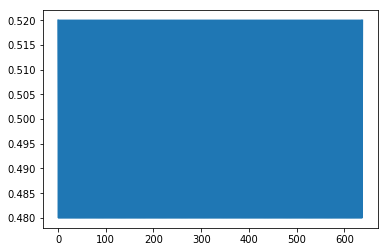

639


In [2]:
plt.figure()
xbin = np.arange(1,3990,10)
print xbin
plt.plot(val_ra)#[xbin])
plt.show()
print np.size(val_ra)

In [4]:
import numpy as np
from numpy.matlib import repmat
import scipy.stats
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from io import StringIO
from scipy import special
from scipy.optimize import minimize
from scipy import sparse
from __future__ import division
Vedges = np.linspace(-1,1.0,2000)
# (gL,vL,N_divide,V,NHYP) = (NetParams.gL,NetParams.vL,NetParams.N_divide,NetParams.V,NetParams.NHYP)ide
(gL,vL,N_divide)=(0.05,0,2000)
vT = 1.0
tau_v = 1/gL
(nbins,nbinp) = (N_divide-1,N_divide)
vLn = vL # + Inmda/gL
# SHAPE OF vLn is [NHYP,2(E/I)]
L_flow = np.zeros([nbins,nbins])
# common params
dV = 2.0/N_divide # Net.h # dV = (vT-(vLn-vT))/nbins
dt = 0.1
(edt,egt) = (np.exp(-dt/tau_v),np.exp(dt/tau_v))
(row_ra,col_ra,val_ra) = ([],[],[])

for j in range(nbins):
    Vpre = Vedges[j]*egt
    Vpos = Vedges[j+1]*egt
    print Vpre,Vpos
    # Vbin [Vpre Vpos] means edges:
    jpre = (Vpre-(vLn-vT))/dV + 1
    jpos = (Vpos-(vLn-vT))/dV + 1
    # print jpre,jpos
    # integer
    jmin = np.floor(jpre)
    jmax = np.ceil(jpos)
    # print jmin,jmax
    # correspondig bin index
    bmin = jmin
    bmax = jmax - 1
    # print bmin,bmax
    # in order
    bvec = np.transpose(np.arange(bmin,(bmax+1)))
    # print bvec
    # distributed weight
    wmin = (jmin+1)-jpre
    wmax = jpos-(jmax-1)
    # print wmin,wmax
    wvec = np.ones([np.size(bvec),1])
    wvec[0,0]  = wmin
    wvec[-1,0] = wmax
    print wvec
    if j>13:
        pause()

    rvec = j*np.ones([np.size(bvec),1])
    # find effective
    tmp = (np.less_equal(bvec,nbins)&np.greater(bvec,0))
    vij = np.where(tmp)


    row_ra = np.append(row_ra,rvec[vij])        
    col_ra = np.append(col_ra,bvec[vij])
    val_ra = np.append(val_ra,wvec[vij])

row_ra = row_ra.flatten()
col_ra = col_ra.flatten()
val_ra = val_ra.flatten()
L_flow = sparse.coo_matrix((val_ra,(row_ra,col_ra)),shape=(nbins+1,nbins+1))
L_flow = L_flow.toarray()
    



#(L_flow,val_ra) = get_L_flow(Vedges)
plt.figure()
plt.imshow(L_flow,cmap='jet')
plt.show()
plt.figure()
plt.plot(val_ra)
plt.show()
plt.figure()
plt.plot(row_ra)
plt.show()
plt.figure()
plt.plot(col_ra)
plt.show()





-1.00501252086 -1.00400700558
[[ 0.01252086]
 [ 0.99299442]]
-1.00400700558 -1.0030014903
[[ 0.00700558]
 [ 0.9985097 ]]
-1.0030014903 -1.00199597502
[[ 0.0014903 ]
 [ 1.        ]
 [ 0.00402498]]
-1.00199597502 -1.00099045975
[[ 0.99597502]
 [ 0.00954025]]
-1.00099045975 -0.999984944467
[[ 0.99045975]
 [ 0.01505553]]
-0.999984944467 -0.998979429188
[[ 0.98494447]
 [ 0.02057081]]
-0.998979429188 -0.99797391391
[[ 0.97942919]
 [ 0.02608609]]
-0.99797391391 -0.996968398631
[[ 0.97391391]
 [ 0.03160137]]
-0.996968398631 -0.995962883353
[[ 0.96839863]
 [ 0.03711665]]
-0.995962883353 -0.994957368074
[[ 0.96288335]
 [ 0.04263193]]
-0.994957368074 -0.993951852796
[[ 0.95736807]
 [ 0.0481472 ]]
-0.993951852796 -0.992946337517
[[ 0.9518528 ]
 [ 0.05366248]]
-0.992946337517 -0.991940822239
[[ 0.94633752]
 [ 0.05917776]]
-0.991940822239 -0.99093530696
[[ 0.94082224]
 [ 0.06469304]]
-0.99093530696 -0.989929791682
[[ 0.93530696]
 [ 0.07020832]]


NameError: name 'pause' is not defined

In [11]:
print dV,edt,egt,tau_v


0.001 0.995012479193 1.00501252086 20.0


In [10]:
import numpy as np
row = []
for i in range(3):
    rowa = (i)*np.ones([1,1])
    row =np.append(row,rowa)

row = row.flatten()
print row
from scipy import sparse
c = sparse.coo_matrix((row,(row,row)),shape=(20,20))
print c  
c = c.toarray()
d = np.ones([1,20])
e = np.dot(d,c)
print e
    

[ 0.  1.  2.]
  (0, 0)	0.0
  (1, 1)	1.0
  (2, 2)	2.0
[[ 0.  1.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]]


In [2]:
Ext = ExtData()
Rec = RecData()
Net = NetParams()
StatV = StatData()
# NETWORK STRUCTURE
(NE,NI,NHYP) = (100,100,2) #(300,100,3)
(vL,gL,V_start,V_end,N_divide) = (0.0,0.05,-1.0,1.0,2000)
(dt,tauN,Final_time,step) = (0.1,80.0,350.0,0)
# connectivity matrix for individual hyper-column
(SEE,SEI,SIE,SII) = (0.369,0.294,0.294,0.369)#(0.16,0.46,0.52,0.24)
(LEE,LIE)         = (0.137,0.262)
# External and LGN feedforward,fast input
(fE,etaE,fI,etaI) = (0.028,1.60,0.028,1.75)#(0.0135,3.8,0.0132,3.5)
(fON,etaON,fOFF,etaOFF) = (0,0,0,0)#(0.0135,3.8,0.0132,3.5)
# Vbin
V = np.linspace(V_start,V_end,N_divide)
V = np.transpose(V)
h = V[1]-V[0]

# NETWORK STRUCTURE
(Net.NE,Net.NI,Net.NHYP) = (NE,NI,NHYP)
(Net.vL,Net.gL,Net.V,Net.h,Net.N_divide,Net.dt,Net.Final_time,Net.tauN) = (vL,gL,V,h,N_divide,dt,Final_time,tauN)
# connectivity matrix for individual hyper-column
(Rec.SEE,Rec.SEI,Rec.SIE,Rec.SII) = (SEE,SEI,SIE,SII)
(Rec.LEE,Rec.LIE)         = (LEE,LIE)
# External and LGN feedforward,fast input
(Ext.fE,Ext.etaE,Ext.fI,Ext.etaI) = (fE,etaE,fI,etaI)
(Ext.fON,Ext.etaON,Ext.fOFF,Ext.etaOFF) = (fE,etaE,fI,etaI)
# PUT TOGETHER


# New narray
mE = np.zeros([NHYP,1])
mI = np.zeros_like(mE)
In = np.zeros([NHYP,2]) # Inh<-Exc or Exc<-Exc
# PUT TOGETHER
Rec.mE = mE
Rec.mI = mI
Rec.In = In
gammaE = np.zeros([NHYP,5])
gammaI = np.zeros_like(gammaE)

# statistical narray
(PEq,PIq)   = (np.zeros([N_divide,NHYP]),np.zeros([N_divide,NHYP]))
(sumE,sumI) = (np.zeros(NHYP),np.zeros(NHYP))
(fiE,fiI)   = (np.zeros([5,NHYP]),np.zeros([5,NHYP]))
(F,FI)      = (np.zeros([2,NHYP]),np.zeros([2,NHYP]))
(La0,LaI0)  = (np.zeros([3,NHYP]),np.zeros([3,NHYP]))
(La1,LaI1)  = (np.zeros([3,NHYP]),np.zeros([3,NHYP]))
(RvE,RvI)  = (np.zeros([N_divide,NHYP]),np.zeros([N_divide,NHYP]))
fin         = np.zeros([NHYP,N_divide,3])   # moment2
counter,t,Max_iteration = 1,0,1



In [3]:
# start, initial state
var1 = pow((5/3/250.0),2)
source = np.exp(-np.square(V-0.0)/var1/2.0)/np.sqrt(2.0*np.pi*var1)
source = source/(h*np.sum(source))
(vbarE,wbarE,vbar3E,vbar4E) = (h*np.sum(V*source),h*(np.sum(np.square(V)*source)),
h*np.sum(np.power(V,3.0)*source),h*np.sum(np.power(V,4.0)*source))
(vbarE,wbarE,vbar3E,vbar4E) = (repmat(vbarE,NHYP,1),repmat(wbarE,NHYP,1),repmat(vbar3E,NHYP,1),
                               repmat(vbar4E,NHYP,1))

(vbarI,wbarI,vbar3I,vbar4I) = (vbarE,wbarE,vbar3E,vbar4E)
       
(VEs,VIs,In) = VQs(Ext,Rec,Net)
(DE,DI)      = DQs(Ext,Rec,Net)
# save state variables
(StatV.VEs,StatV.VIs,StatV.DE,StatV.DI) = (VEs,VIs,DE,DI)
(StatV.vbarE,StatV.wbarE,StatV.vbar3E,StatV.vbar4E) = (vbarE,wbarE,vbar3E,vbar4E)
(StatV.vbarI,StatV.wbarI,StatV.vbar3I,StatV.vbar4I) = (vbarI,wbarI,vbar3I,vbar4I)
# testing and printing
# print 'VE: ',VEs
# print 'VI: ',VIs
# print 'DE: ',DE
# print 'DI: ',DI
# plt.figure()
for i in range(NHYP):
    (PEq[:,i],sumE[i]) = rho_EQ(VEs[i],DE[i],V)
    (PIq[:,i],sumI[i]) = rho_EQ(VIs[i],DI[i],V)
    gammaE[i,:] = [1,vbarE[i],wbarE[i],vbar3E[i],vbar4E[i]]
    gammaI[i,:] = [1,vbarI[i],wbarI[i],vbar3I[i],vbar4I[i]]
    fiE[:,i] = np.transpose(gammaE[i,:])
    fiI[:,i] = np.transpose(gammaI[i,:])
    moment2 = 1
    if moment2:
        F[:,i]  = fiE[1:3,i]
        FI[:,i] = fiI[1:3,i]
        La0[:,i]= np.transpose(gammaE[i,0:3])
        LaI0[:,i] = np.transpose(gammaI[i,0:3])
    N = np.size(np.squeeze(La0[:,i]))
    fin[i,:,0] = 1
    # check!
    Ncheck = np.size(np.squeeze(fin[i,0,:]))
    
    for n in range(1,N):
        fin[i,:,n] = V*fin[i,:,n-1]
    # plt.plot(np.squeeze(PEq[i,:]))
# plt.show()



In [4]:
print wbarE

[[  4.44444444e-05]
 [  4.44444444e-05]]


In [5]:
# INITIATE STARTING STATE
times = 10000
(sum_mE,sum_mI)  = (0.0,0.0)
counter_firing_step = 0
counter = 1
t = 0.0
while (t< Final_time):
    (VEs,VIs,In) = VQs(Ext,Rec,Net)
    (DE,DI)      = DQs(Ext,Rec,Net) 
    # save state variables
    (StatV.VEs,StatV.VIs,StatV.DE,StatV.DI) = (VEs,VIs,DE,DI)
    # print 'VEs: ',StatV.VEs,'VIs: ',StatV.VIs,'DE: ',StatV.DE,'DI: ',StatV.DI
    [vbarE,vbarI,wbarE,wbarI,vbar3E,vbar3I,vbar4E,vbar4I] = solveVbarWbar4(Net,StatV,Rec)
    # print 'mu and D',vbarE,vbarI,wbarE,wbarI,vbar3E,vbar3I,vbar4E,vbar4I

    
    (StatV.vbarE,StatV.wbarE,StatV.vbar3E,StatV.vbar4E) = (vbarE,wbarE,vbar3E,vbar4E)
    (StatV.vbarI,StatV.wbarI,StatV.vbar3I,StatV.vbar4I) = (vbarI,wbarI,vbar3I,vbar4I)
    
    for i in range(NHYP):
        (PEq[:,i],sumE[i]) = rho_EQ(VEs[i],DE[i],V)
        (PIq[:,i],sumI[i]) = rho_EQ(VIs[i],DI[i],V)
        gammaE[i,:] = [1,vbarE[i],wbarE[i],vbar3E[i],vbar4E[i]]
        gammaI[i,:] = [1,vbarI[i],wbarI[i],vbar3I[i],vbar4I[i]]
        fiE[:,i] = np.transpose(gammaE[i,:])
        fiI[:,i] = np.transpose(gammaI[i,:])
        # print 'fiE: ',fiE[:,i],'fiI: ',fiI[:,i]
        
        moment2 = 1
        if moment2:
            F[:,i]  = fiE[1:3,i]
            FI[:,i] = fiI[1:3,i]
            # def optfun(lambda_u,mu,x,PEq,fin,gamma):
            (tmu,tx,tPEq,tfin,tgamma) = (F[:,i],V,PEq[:,i],fin[i,:,:],1)
            # N-order,1),Vbin,1),Vbin,1),Vbin,N-order),
            a0 = La0[:,i]
            # print 'F/FI: ',F[:,i],FI[:,i]
            # print 'params: ',a0,tmu,tgamma
            res = minimize(optfun,a0,args=(tmu,tx,tPEq,tfin,tgamma),options={'disp': False})
            # print res
            La1[:,i] = res.x
            # print res.x
            (tmu,tx,tPIq,tfin,tgamma) = (FI[:,i],V,PIq[:,i],fin[i,:,:],1)  
            a0 = LaI0[:,i]
            res = minimize(optfun,a0,args=(tmu,tx,tPIq,tfin,tgamma),options={'disp': False})
            LaI1[:,i] = res.x
            La0[:,i] = np.real(La1[:,i])
            LaI0[:,i]= np.real(LaI1[:,i])
            
            RvE[:,i] = PEq[:,i]*np.exp(np.dot(np.squeeze(fin[i,:,:]),La1[:,i]))
            RvI[:,i] = PIq[:,i]*np.exp(np.dot(np.squeeze(fin[i,:,:]),LaI1[:,i]))
            # normalization
            RvE[:,i] = RvE[:,i]/((V[1]-V[0])*np.sum(RvE[:,i]))
            RvI[:,i] = RvI[:,i]/((V[1]-V[0])*np.sum(RvI[:,i]))
            mE[i] = gL*np.sqrt(DE[i])*np.exp(np.sum(La1[:,i]))/sumE[i]/2
            mI[i] = gL*np.sqrt(DI[i])*np.exp(np.sum(LaI1[:,i]))/sumI[i]/2
            
    # PUT TOGETHER
    Rec.mE = mE
    Rec.mI = mI
    Rec.In = In
    print 'mE: ',Rec.mE,'\n mI: ',Rec.mI,'\n iNMDA: ',Rec.In
    t = dt*counter
    counter = counter + 1
    step    = step + 1
    """
    if step ==5:
        plt.plot(V,RvE[:,0])
        plt.show()
        step = 0
    """    
    

mE:  [[ 0.]
 [ 0.]] 
 mI:  [[ 0.]
 [ 0.]] 
 iNMDA:  [[ 0.  0.]
 [ 0.  0.]]
mE:  [[ 0.]
 [ 0.]] 
 mI:  [[ 0.]
 [ 0.]] 
 iNMDA:  [[ 0.  0.]
 [ 0.  0.]]
mE:  [[ 0.]
 [ 0.]] 
 mI:  [[ 0.]
 [ 0.]] 
 iNMDA:  [[ 0.  0.]
 [ 0.  0.]]
mE:  [[  4.82523863e-285]
 [  4.82523863e-285]] 
 mI:  [[  2.29864106e-269]
 [  2.29864106e-269]] 
 iNMDA:  [[ 0.  0.]
 [ 0.  0.]]
mE:  [[  1.93548065e-235]
 [  1.93548065e-235]] 
 mI:  [[  1.04993160e-223]
 [  1.04993160e-223]] 
 iNMDA:  [[  8.25805879e-289   1.57927840e-288]
 [  8.25805879e-289   1.57927840e-288]]
mE:  [[  2.07561804e-203]
 [  2.07561804e-203]] 
 mI:  [[  4.37714523e-194]
 [  4.37714523e-194]] 
 iNMDA:  [[  3.31243990e-239   6.33473908e-239]
 [  3.31243990e-239   6.33473908e-239]]
mE:  [[  5.40354876e-181]
 [  5.40354876e-181]] 
 mI:  [[  3.78637800e-173]
 [  3.78637800e-173]] 
 iNMDA:  [[  3.55227526e-207   6.79340232e-207]
 [  3.55227526e-207   6.79340232e-207]]
mE:  [[  2.77980379e-164]
 [  2.77980379e-164]] 
 mI:  [[  2.39730427e-157]
 [  2.3

mE:  [[  5.61338246e-34]
 [  5.61338246e-34]] 
 mI:  [[  3.08933509e-30]
 [  3.08933509e-30]] 
 iNMDA:  [[  1.94850588e-38   3.72633971e-38]
 [  1.94850588e-38   3.72633971e-38]]
mE:  [[  3.05641961e-33]
 [  3.05641961e-33]] 
 mI:  [[  1.53226357e-29]
 [  1.53226357e-29]] 
 iNMDA:  [[  1.15529837e-37   2.20940271e-37]
 [  1.15529837e-37   2.20940271e-37]]
mE:  [[  1.56787991e-32]
 [  1.56787991e-32]] 
 mI:  [[  7.07264785e-29]
 [  7.07264785e-29]] 
 iNMDA:  [[  6.38470377e-37   1.22101634e-36]
 [  6.38470377e-37   1.22101634e-36]]
mE:  [[  7.59932622e-32]
 [  7.59932622e-32]] 
 mI:  [[  3.13080997e-28]
 [  3.13080997e-28]] 
 iNMDA:  [[  3.32098971e-36   6.35108981e-36]
 [  3.32098971e-36   6.35108981e-36]]
mE:  [[  3.48267185e-31]
 [  3.48267185e-31]] 
 mI:  [[  1.29265369e-27]
 [  1.29265369e-27]] 
 iNMDA:  [[  1.63225570e-35   3.12154009e-35]
 [  1.63225570e-35   3.12154009e-35]]
mE:  [[  1.50888376e-30]
 [  1.50888376e-30]] 
 mI:  [[  5.07658500e-27]
 [  5.07658500e-27]] 
 iNMDA:  [

mE:  [[  5.91664333e-16]
 [  5.91664333e-16]] 
 mI:  [[  1.82846879e-13]
 [  1.82846879e-13]] 
 iNMDA:  [[  1.78066522e-19   3.40535976e-19]
 [  1.78066522e-19   3.40535976e-19]]
mE:  [[  9.01110010e-16]
 [  9.01110010e-16]] 
 mI:  [[  2.70404345e-13]
 [  2.70404345e-13]] 
 iNMDA:  [[  2.79103294e-19   5.33759585e-19]
 [  2.79103294e-19   5.33759585e-19]]
mE:  [[  1.35965676e-15]
 [  1.35965676e-15]] 
 mI:  [[  3.96887216e-13]
 [  3.96887216e-13]] 
 iNMDA:  [[  4.32973316e-19   8.28021961e-19]
 [  4.32973316e-19   8.28021961e-19]]
mE:  [[  2.02916565e-15]
 [  2.02916565e-15]] 
 mI:  [[  5.77330651e-13]
 [  5.77330651e-13]] 
 iNMDA:  [[  6.65128192e-19   1.27199698e-18]
 [  6.65128192e-19   1.27199698e-18]]
mE:  [[  3.00304806e-15]
 [  3.00304806e-15]] 
 mI:  [[  8.31132488e-13]
 [  8.31132488e-13]] 
 iNMDA:  [[  1.01157483e-18   1.93454456e-18]
 [  1.01157483e-18   1.93454456e-18]]
mE:  [[  4.40568341e-15]
 [  4.40568341e-15]] 
 mI:  [[  1.18957080e-12]
 [  1.18957080e-12]] 
 iNMDA:  [

mE:  [[  3.24544876e-10]
 [  3.24544876e-10]] 
 mI:  [[  4.40461099e-08]
 [  4.40461099e-08]] 
 iNMDA:  [[  2.78877716e-13   5.33328188e-13]
 [  2.78877716e-13   5.33328188e-13]]
mE:  [[  3.81443792e-10]
 [  3.81443792e-10]] 
 mI:  [[  5.10409948e-08]
 [  5.10409948e-08]] 
 iNMDA:  [[  3.34072925e-13   6.38883988e-13]
 [  3.34072925e-13   6.38883988e-13]]
mE:  [[  4.47544767e-10]
 [  4.47544767e-10]] 
 mI:  [[  5.90089860e-08]
 [  5.90089860e-08]] 
 iNMDA:  [[  3.98937035e-13   7.62930680e-13]
 [  3.98937035e-13   7.62930680e-13]]
mE:  [[  5.24061079e-10]
 [  5.24061079e-10]] 
 mI:  [[  6.80791396e-08]
 [  6.80791396e-08]] 
 iNMDA:  [[  4.75032835e-13   9.08456955e-13]
 [  4.75032835e-13   9.08456955e-13]]
mE:  [[  6.35646795e-10]
 [  6.35646795e-10]] 
 mI:  [[  8.08841466e-08]
 [  8.08841466e-08]] 
 iNMDA:  [[  5.64128807e-13   1.07884487e-12]
 [  5.64128807e-13   1.07884487e-12]]
mE:  [[  7.41488600e-10]
 [  7.41488600e-10]] 
 mI:  [[  9.29823237e-08]
 [  9.29823237e-08]] 
 iNMDA:  [

mE:  [[  2.08050104e-07]
 [  2.08050104e-07]] 
 mI:  [[  1.45589766e-05]
 [  1.45589766e-05]] 
 iNMDA:  [[  2.92654140e-10   5.59674340e-10]
 [  2.92654140e-10   5.59674340e-10]]
mE:  [[  2.27425707e-07]
 [  2.27425707e-07]] 
 mI:  [[  1.57219955e-05]
 [  1.57219955e-05]] 
 iNMDA:  [[  3.27894872e-10   6.27069026e-10]
 [  3.27894872e-10   6.27069026e-10]]
mE:  [[  2.56392207e-07]
 [  2.56392207e-07]] 
 mI:  [[  1.74338402e-05]
 [  1.74338402e-05]] 
 iNMDA:  [[  3.66407581e-10   7.00721066e-10]
 [  3.66407581e-10   7.00721066e-10]]
mE:  [[  2.79727313e-07]
 [  2.79727313e-07]] 
 mI:  [[  1.87915629e-05]
 [  1.87915629e-05]] 
 iNMDA:  [[  4.09829592e-10   7.83761702e-10]
 [  4.09829592e-10   7.83761702e-10]]
mE:  [[  3.14970022e-07]
 [  3.14970022e-07]] 
 mI:  [[  2.08137756e-05]
 [  2.08137756e-05]] 
 iNMDA:  [[  4.57191000e-10   8.74336074e-10]
 [  4.57191000e-10   8.74336074e-10]]
mE:  [[  3.42952875e-07]
 [  3.42952875e-07]] 
 mI:  [[  2.27062557e-05]
 [  2.27062557e-05]] 
 iNMDA:  [

mE:  [[  1.59332142e-05]
 [  1.59332142e-05]] 
 mI:  [[ 0.00059186]
 [ 0.00059186]] 
 iNMDA:  [[  3.32697727e-08   6.36254047e-08]
 [  3.32697727e-08   6.36254047e-08]]
mE:  [[  1.70772670e-05]
 [  1.70772670e-05]] 
 mI:  [[ 0.00062914]
 [ 0.00062914]] 
 iNMDA:  [[  3.59550698e-08   6.87607903e-08]
 [  3.59550698e-08   6.87607903e-08]]
mE:  [[  1.82997573e-05]
 [  1.82997573e-05]] 
 mI:  [[ 0.00066849]
 [ 0.00066849]] 
 iNMDA:  [[  3.88328089e-08   7.42642039e-08]
 [  3.88328089e-08   7.42642039e-08]]
mE:  [[  1.95961366e-05]
 [  1.95961366e-05]] 
 mI:  [[ 0.00070989]
 [ 0.00070989]] 
 iNMDA:  [[  4.19161738e-08   8.01608580e-08]
 [  4.19161738e-08   8.01608580e-08]]
mE:  [[  2.09671831e-05]
 [  2.09671831e-05]] 
 mI:  [[ 0.00075356]
 [ 0.00075356]] 
 iNMDA:  [[  4.52175532e-08   8.64744449e-08]
 [  4.52175532e-08   8.64744449e-08]]
mE:  [[  2.24352950e-05]
 [  2.24352950e-05]] 
 mI:  [[ 0.00079996]
 [ 0.00079996]] 
 iNMDA:  [[  4.87494535e-08   9.32288818e-08]
 [  4.87494535e-08   9.3

mE:  [[ 0.00027543]
 [ 0.00027543]] 
 mI:  [[ 0.00813267]
 [ 0.00813267]] 
 iNMDA:  [[  8.68546654e-07   1.66101623e-06]
 [  8.68546654e-07   1.66101623e-06]]
mE:  [[ 0.00028787]
 [ 0.00028787]] 
 mI:  [[ 0.00840009]
 [ 0.00840009]] 
 iNMDA:  [[  9.14600301e-07   1.74908963e-06]
 [  9.14600301e-07   1.74908963e-06]]
mE:  [[ 0.00030075]
 [ 0.00030075]] 
 mI:  [[ 0.00867384]
 [ 0.00867384]] 
 iNMDA:  [[  9.62724739e-07   1.84112322e-06]
 [  9.62724739e-07   1.84112322e-06]]
mE:  [[ 0.00031412]
 [ 0.00031412]] 
 mI:  [[ 0.00893796]
 [ 0.00893796]] 
 iNMDA:  [[  1.01299409e-06   1.93725877e-06]
 [  1.01299409e-06   1.93725877e-06]]
mE:  [[ 0.00032808]
 [ 0.00032808]] 
 mI:  [[ 0.00920292]
 [ 0.00920292]] 
 iNMDA:  [[  1.06548819e-06   2.03764895e-06]
 [  1.06548819e-06   2.03764895e-06]]
mE:  [[ 0.00034238]
 [ 0.00034238]] 
 mI:  [[ 0.00946404]
 [ 0.00946404]] 
 iNMDA:  [[  1.12030655e-06   2.14248405e-06]
 [  1.12030655e-06   2.14248405e-06]]
mE:  [[ 0.00035707]
 [ 0.00035707]] 
 mI:  [[ 

mE:  [[ 0.00164455]
 [ 0.00164455]] 
 mI:  [[ 0.0155516]
 [ 0.0155516]] 
 iNMDA:  [[  8.44299928e-06   1.61464658e-05]
 [  8.44299928e-06   1.61464658e-05]]
mE:  [[ 0.00168296]
 [ 0.00168296]] 
 mI:  [[ 0.01557223]
 [ 0.01557223]] 
 iNMDA:  [[  8.71390534e-06   1.66645489e-05]
 [  8.71390534e-06   1.66645489e-05]]
mE:  [[ 0.00172236]
 [ 0.00172236]] 
 mI:  [[ 0.01559075]
 [ 0.01559075]] 
 iNMDA:  [[  8.99104666e-06   1.71945564e-05]
 [  8.99104666e-06   1.71945564e-05]]
mE:  [[ 0.00176202]
 [ 0.00176202]] 
 mI:  [[ 0.0156085]
 [ 0.0156085]] 
 iNMDA:  [[  9.27458497e-06   1.77367975e-05]
 [  9.27458497e-06   1.77367975e-05]]
mE:  [[ 0.00180243]
 [ 0.00180243]] 
 mI:  [[ 0.01562319]
 [ 0.01562319]] 
 iNMDA:  [[  9.56455607e-06   1.82913408e-05]
 [  9.56455607e-06   1.82913408e-05]]
mE:  [[ 0.00184346]
 [ 0.00184346]] 
 mI:  [[ 0.01563622]
 [ 0.01563622]] 
 iNMDA:  [[  9.86108117e-06   1.88584180e-05]
 [  9.86108117e-06   1.88584180e-05]]
mE:  [[ 0.00188509]
 [ 0.00188509]] 
 mI:  [[ 0.01

mE:  [[ 0.00482744]
 [ 0.00482744]] 
 mI:  [[ 0.01540011]
 [ 0.01540011]] 
 iNMDA:  [[  3.48626834e-05   6.66717011e-05]
 [  3.48626834e-05   6.66717011e-05]]
mE:  [[ 0.00491237]
 [ 0.00491237]] 
 mI:  [[ 0.01539357]
 [ 0.01539357]] 
 iNMDA:  [[  3.56453141e-05   6.81684109e-05]
 [  3.56453141e-05   6.81684109e-05]]
mE:  [[ 0.00499917]
 [ 0.00499917]] 
 mI:  [[ 0.0153874]
 [ 0.0153874]] 
 iNMDA:  [[  3.64415025e-05   6.96910487e-05]
 [  3.64415025e-05   6.96910487e-05]]
mE:  [[ 0.00508632]
 [ 0.00508632]] 
 mI:  [[ 0.01538169]
 [ 0.01538169]] 
 iNMDA:  [[  3.72515515e-05   7.12401934e-05]
 [  3.72515515e-05   7.12401934e-05]]
mE:  [[ 0.00517448]
 [ 0.00517448]] 
 mI:  [[ 0.01537616]
 [ 0.01537616]] 
 iNMDA:  [[  3.80755038e-05   7.28159270e-05]
 [  3.80755038e-05   7.28159270e-05]]
mE:  [[ 0.00526368]
 [ 0.00526368]] 
 mI:  [[ 0.01537112]
 [ 0.01537112]] 
 iNMDA:  [[  3.89135149e-05   7.44185467e-05]
 [  3.89135149e-05   7.44185467e-05]]
mE:  [[ 0.00535409]
 [ 0.00535409]] 
 mI:  [[ 0.

mE:  [[ 0.01074546]
 [ 0.01074546]] 
 mI:  [[ 0.01573321]
 [ 0.01573321]] 
 iNMDA:  [[  9.74282465e-05   1.86322632e-04]
 [  9.74282465e-05   1.86322632e-04]]
mE:  [[ 0.01088651]
 [ 0.01088651]] 
 mI:  [[ 0.01575437]
 [ 0.01575437]] 
 iNMDA:  [[  9.91455475e-05   1.89606813e-04]
 [  9.91455475e-05   1.89606813e-04]]
mE:  [[ 0.01102994]
 [ 0.01102994]] 
 mI:  [[ 0.01577765]
 [ 0.01577765]] 
 iNMDA:  [[ 0.00010088  0.00019293]
 [ 0.00010088  0.00019293]]
mE:  [[ 0.01117101]
 [ 0.01117101]] 
 mI:  [[ 0.01580046]
 [ 0.01580046]] 
 iNMDA:  [[ 0.00010265  0.0001963 ]
 [ 0.00010265  0.0001963 ]]
mE:  [[ 0.01131371]
 [ 0.01131371]] 
 mI:  [[ 0.01582348]
 [ 0.01582348]] 
 iNMDA:  [[ 0.00010443  0.00019971]
 [ 0.00010443  0.00019971]]
mE:  [[ 0.01145901]
 [ 0.01145901]] 
 mI:  [[ 0.01584745]
 [ 0.01584745]] 
 iNMDA:  [[ 0.00010624  0.00020317]
 [ 0.00010624  0.00020317]]
mE:  [[ 0.0116027]
 [ 0.0116027]] 
 mI:  [[ 0.01587237]
 [ 0.01587237]] 
 iNMDA:  [[ 0.00010806  0.00020666]
 [ 0.00010806  0.

mE:  [[ 0.01836689]
 [ 0.01836689]] 
 mI:  [[ 0.01735287]
 [ 0.01735287]] 
 iNMDA:  [[ 0.00024063  0.00046019]
 [ 0.00024063  0.00046019]]
mE:  [[ 0.01842564]
 [ 0.01842564]] 
 mI:  [[ 0.01737625]
 [ 0.01737625]] 
 iNMDA:  [[ 0.00024348  0.00046562]
 [ 0.00024348  0.00046562]]
mE:  [[ 0.01847554]
 [ 0.01847554]] 
 mI:  [[ 0.0173874]
 [ 0.0173874]] 
 iNMDA:  [[ 0.00024632  0.00047107]
 [ 0.00024632  0.00047107]]
mE:  [[ 0.01852306]
 [ 0.01852306]] 
 mI:  [[ 0.01739131]
 [ 0.01739131]] 
 iNMDA:  [[ 0.00024918  0.00047653]
 [ 0.00024918  0.00047653]]
mE:  [[ 0.01857016]
 [ 0.01857016]] 
 mI:  [[ 0.0174098]
 [ 0.0174098]] 
 iNMDA:  [[ 0.00025204  0.000482  ]
 [ 0.00025204  0.000482  ]]
mE:  [[ 0.01860793]
 [ 0.01860793]] 
 mI:  [[ 0.01741808]
 [ 0.01741808]] 
 iNMDA:  [[ 0.0002549   0.00048747]
 [ 0.0002549   0.00048747]]
mE:  [[ 0.01864419]
 [ 0.01864419]] 
 mI:  [[ 0.0174282]
 [ 0.0174282]] 
 iNMDA:  [[ 0.00025777  0.00049296]
 [ 0.00025777  0.00049296]]
mE:  [[ 0.01867505]
 [ 0.01867505

mE:  [[ 0.01606178]
 [ 0.01606178]] 
 mI:  [[ 0.01648328]
 [ 0.01648328]] 
 iNMDA:  [[ 0.0004038   0.00077223]
 [ 0.0004038   0.00077223]]
mE:  [[ 0.01597652]
 [ 0.01597652]] 
 mI:  [[ 0.01646542]
 [ 0.01646542]] 
 iNMDA:  [[ 0.00040604  0.00077652]
 [ 0.00040604  0.00077652]]
mE:  [[ 0.01589042]
 [ 0.01589042]] 
 mI:  [[ 0.01642274]
 [ 0.01642274]] 
 iNMDA:  [[ 0.00040827  0.00078078]
 [ 0.00040827  0.00078078]]
mE:  [[ 0.01580433]
 [ 0.01580433]] 
 mI:  [[ 0.01640717]
 [ 0.01640717]] 
 iNMDA:  [[ 0.00041048  0.000785  ]
 [ 0.00041048  0.000785  ]]
mE:  [[ 0.01571826]
 [ 0.01571826]] 
 mI:  [[ 0.01636231]
 [ 0.01636231]] 
 iNMDA:  [[ 0.00041267  0.00078919]
 [ 0.00041267  0.00078919]]
mE:  [[ 0.01563214]
 [ 0.01563214]] 
 mI:  [[ 0.01634855]
 [ 0.01634855]] 
 iNMDA:  [[ 0.00041485  0.00079335]
 [ 0.00041485  0.00079335]]
mE:  [[ 0.01554693]
 [ 0.01554693]] 
 mI:  [[ 0.01630205]
 [ 0.01630205]] 
 iNMDA:  [[ 0.000417    0.00079748]
 [ 0.000417    0.00079748]]
mE:  [[ 0.01546098]
 [ 0.01

mE:  [[ 0.01180542]
 [ 0.01180542]] 
 mI:  [[ 0.01502965]
 [ 0.01502965]] 
 iNMDA:  [[ 0.00051214  0.00097943]
 [ 0.00051214  0.00097943]]
mE:  [[ 0.01175856]
 [ 0.01175856]] 
 mI:  [[ 0.01501504]
 [ 0.01501504]] 
 iNMDA:  [[ 0.00051352  0.00098207]
 [ 0.00051352  0.00098207]]
mE:  [[ 0.01171395]
 [ 0.01171395]] 
 mI:  [[ 0.01500899]
 [ 0.01500899]] 
 iNMDA:  [[ 0.00051489  0.00098469]
 [ 0.00051489  0.00098469]]
mE:  [[ 0.01166714]
 [ 0.01166714]] 
 mI:  [[ 0.01498335]
 [ 0.01498335]] 
 iNMDA:  [[ 0.00051626  0.00098729]
 [ 0.00051626  0.00098729]]
mE:  [[ 0.01162556]
 [ 0.01162556]] 
 mI:  [[ 0.01497363]
 [ 0.01497363]] 
 iNMDA:  [[ 0.00051761  0.00098988]
 [ 0.00051761  0.00098988]]
mE:  [[ 0.01158197]
 [ 0.01158197]] 
 mI:  [[ 0.01496754]
 [ 0.01496754]] 
 iNMDA:  [[ 0.00051895  0.00099245]
 [ 0.00051895  0.00099245]]
mE:  [[ 0.01153713]
 [ 0.01153713]] 
 mI:  [[ 0.0149428]
 [ 0.0149428]] 
 iNMDA:  [[ 0.00052028  0.000995  ]
 [ 0.00052028  0.000995  ]]
mE:  [[ 0.01149812]
 [ 0.0114

mE:  [[ 0.01012362]
 [ 0.01012362]] 
 mI:  [[ 0.01463207]
 [ 0.01463207]] 
 iNMDA:  [[ 0.00058623  0.00112111]
 [ 0.00058623  0.00112111]]
mE:  [[ 0.01011609]
 [ 0.01011609]] 
 mI:  [[ 0.01464102]
 [ 0.01464102]] 
 iNMDA:  [[ 0.00058723  0.00112302]
 [ 0.00058723  0.00112302]]
mE:  [[ 0.01010558]
 [ 0.01010558]] 
 mI:  [[ 0.01464037]
 [ 0.01464037]] 
 iNMDA:  [[ 0.00058823  0.00112493]
 [ 0.00058823  0.00112493]]
mE:  [[ 0.01009655]
 [ 0.01009655]] 
 mI:  [[ 0.0146441]
 [ 0.0146441]] 
 iNMDA:  [[ 0.00058922  0.00112683]
 [ 0.00058922  0.00112683]]
mE:  [[ 0.01008763]
 [ 0.01008763]] 
 mI:  [[ 0.01464553]
 [ 0.01464553]] 
 iNMDA:  [[ 0.00059021  0.00112873]
 [ 0.00059021  0.00112873]]
mE:  [[ 0.01007915]
 [ 0.01007915]] 
 mI:  [[ 0.01463855]
 [ 0.01463855]] 
 iNMDA:  [[ 0.0005912   0.00113062]
 [ 0.0005912   0.00113062]]
mE:  [[ 0.01007349]
 [ 0.01007349]] 
 mI:  [[ 0.01464695]
 [ 0.01464695]] 
 iNMDA:  [[ 0.00059219  0.00113251]
 [ 0.00059219  0.00113251]]
mE:  [[ 0.01006547]
 [ 0.0100

 [ 0.01491007]] 
 iNMDA:  [[ 0.00064325  0.00123016]
 [ 0.00064325  0.00123016]]
mE:  [[ 0.01013944]
 [ 0.01013944]] 
 mI:  [[ 0.01491306]
 [ 0.01491306]] 
 iNMDA:  [[ 0.00064418  0.00123194]
 [ 0.00064418  0.00123194]]
mE:  [[ 0.01014428]
 [ 0.01014428]] 
 mI:  [[ 0.01492169]
 [ 0.01492169]] 
 iNMDA:  [[ 0.00064511  0.00123372]
 [ 0.00064511  0.00123372]]
mE:  [[ 0.01015283]
 [ 0.01015283]] 
 mI:  [[ 0.01492457]
 [ 0.01492457]] 
 iNMDA:  [[ 0.00064604  0.0012355 ]
 [ 0.00064604  0.0012355 ]]
mE:  [[ 0.01016612]
 [ 0.01016612]] 
 mI:  [[ 0.01494011]
 [ 0.01494011]] 
 iNMDA:  [[ 0.00064697  0.00123728]
 [ 0.00064697  0.00123728]]
mE:  [[ 0.01017615]
 [ 0.01017615]] 
 mI:  [[ 0.01494264]
 [ 0.01494264]] 
 iNMDA:  [[ 0.00064791  0.00123906]
 [ 0.00064791  0.00123906]]
mE:  [[ 0.01017965]
 [ 0.01017965]] 
 mI:  [[ 0.01495166]
 [ 0.01495166]] 
 iNMDA:  [[ 0.00064884  0.00124084]
 [ 0.00064884  0.00124084]]
mE:  [[ 0.01018695]
 [ 0.01018695]] 
 mI:  [[ 0.01495364]
 [ 0.01495364]] 
 iNMDA:  [

mE:  [[ 0.01085748]
 [ 0.01085748]] 
 mI:  [[ 0.01538437]
 [ 0.01538437]] 
 iNMDA:  [[ 0.00070215  0.0013428 ]
 [ 0.00070215  0.0013428 ]]
mE:  [[ 0.01087655]
 [ 0.01087655]] 
 mI:  [[ 0.01540153]
 [ 0.01540153]] 
 iNMDA:  [[ 0.00070313  0.00134467]
 [ 0.00070313  0.00134467]]
mE:  [[ 0.01088531]
 [ 0.01088531]] 
 mI:  [[ 0.0154031]
 [ 0.0154031]] 
 iNMDA:  [[ 0.00070411  0.00134655]
 [ 0.00070411  0.00134655]]
mE:  [[ 0.01090383]
 [ 0.01090383]] 
 mI:  [[ 0.01540828]
 [ 0.01540828]] 
 iNMDA:  [[ 0.0007051   0.00134843]
 [ 0.0007051   0.00134843]]
mE:  [[ 0.01091775]
 [ 0.01091775]] 
 mI:  [[ 0.0154256]
 [ 0.0154256]] 
 iNMDA:  [[ 0.00070608  0.00135032]
 [ 0.00070608  0.00135032]]
mE:  [[ 0.01093178]
 [ 0.01093178]] 
 mI:  [[ 0.01542374]
 [ 0.01542374]] 
 iNMDA:  [[ 0.00070707  0.0013522 ]
 [ 0.00070707  0.0013522 ]]
mE:  [[ 0.0109461]
 [ 0.0109461]] 
 mI:  [[ 0.01543528]
 [ 0.01543528]] 
 iNMDA:  [[ 0.00070806  0.00135409]
 [ 0.00070806  0.00135409]]
mE:  [[ 0.0109617]
 [ 0.0109617]]

mE:  [[ 0.01166456]
 [ 0.01166456]] 
 mI:  [[ 0.01579727]
 [ 0.01579727]] 
 iNMDA:  [[ 0.00076402  0.00146112]
 [ 0.00076402  0.00146112]]
mE:  [[ 0.0116684]
 [ 0.0116684]] 
 mI:  [[ 0.01579943]
 [ 0.01579943]] 
 iNMDA:  [[ 0.00076506  0.00146311]
 [ 0.00076506  0.00146311]]
mE:  [[ 0.01168396]
 [ 0.01168396]] 
 mI:  [[ 0.01580036]
 [ 0.01580036]] 
 iNMDA:  [[ 0.0007661  0.0014651]
 [ 0.0007661  0.0014651]]
mE:  [[ 0.01169405]
 [ 0.01169405]] 
 mI:  [[ 0.01580868]
 [ 0.01580868]] 
 iNMDA:  [[ 0.00076715  0.0014671 ]
 [ 0.00076715  0.0014671 ]]
mE:  [[ 0.01170685]
 [ 0.01170685]] 
 mI:  [[ 0.01581066]
 [ 0.01581066]] 
 iNMDA:  [[ 0.00076819  0.00146909]
 [ 0.00076819  0.00146909]]
mE:  [[ 0.0117137]
 [ 0.0117137]] 
 mI:  [[ 0.01581713]
 [ 0.01581713]] 
 iNMDA:  [[ 0.00076923  0.00147109]
 [ 0.00076923  0.00147109]]
mE:  [[ 0.01172732]
 [ 0.01172732]] 
 mI:  [[ 0.01582709]
 [ 0.01582709]] 
 iNMDA:  [[ 0.00077028  0.00147309]
 [ 0.00077028  0.00147309]]
mE:  [[ 0.01173692]
 [ 0.01173692]]

mE:  [[ 0.01211477]
 [ 0.01211477]] 
 mI:  [[ 0.01601497]
 [ 0.01601497]] 
 iNMDA:  [[ 0.00083503  0.00159691]
 [ 0.00083503  0.00159691]]
mE:  [[ 0.01211705]
 [ 0.01211705]] 
 mI:  [[ 0.01601966]
 [ 0.01601966]] 
 iNMDA:  [[ 0.00083606  0.00159888]
 [ 0.00083606  0.00159888]]
mE:  [[ 0.01211459]
 [ 0.01211459]] 
 mI:  [[ 0.01601874]
 [ 0.01601874]] 
 iNMDA:  [[ 0.00083709  0.00160085]
 [ 0.00083709  0.00160085]]
mE:  [[ 0.01212116]
 [ 0.01212116]] 
 mI:  [[ 0.01601925]
 [ 0.01601925]] 
 iNMDA:  [[ 0.00083811  0.00160281]
 [ 0.00083811  0.00160281]]
mE:  [[ 0.01212374]
 [ 0.01212374]] 
 mI:  [[ 0.01602401]
 [ 0.01602401]] 
 iNMDA:  [[ 0.00083914  0.00160478]
 [ 0.00083914  0.00160478]]
mE:  [[ 0.01212145]
 [ 0.01212145]] 
 mI:  [[ 0.01602336]
 [ 0.01602336]] 
 iNMDA:  [[ 0.00084017  0.00160674]
 [ 0.00084017  0.00160674]]
mE:  [[ 0.01212714]
 [ 0.01212714]] 
 mI:  [[ 0.01602384]
 [ 0.01602384]] 
 iNMDA:  [[ 0.00084119  0.0016087 ]
 [ 0.00084119  0.0016087 ]]
mE:  [[ 0.01212914]
 [ 0.01

mE:  [[ 0.01208323]
 [ 0.01208323]] 
 mI:  [[ 0.01605914]
 [ 0.01605914]] 
 iNMDA:  [[ 0.00090043  0.00172199]
 [ 0.00090043  0.00172199]]
mE:  [[ 0.01208071]
 [ 0.01208071]] 
 mI:  [[ 0.01605773]
 [ 0.01605773]] 
 iNMDA:  [[ 0.00090137  0.0017238 ]
 [ 0.00090137  0.0017238 ]]
mE:  [[ 0.01207928]
 [ 0.01207928]] 
 mI:  [[ 0.01605973]
 [ 0.01605973]] 
 iNMDA:  [[ 0.00090232  0.0017256 ]
 [ 0.00090232  0.0017256 ]]
mE:  [[ 0.01207684]
 [ 0.01207684]] 
 mI:  [[ 0.01605999]
 [ 0.01605999]] 
 iNMDA:  [[ 0.00090326  0.00172739]
 [ 0.00090326  0.00172739]]
mE:  [[ 0.01207461]
 [ 0.01207461]] 
 mI:  [[ 0.01606077]
 [ 0.01606077]] 
 iNMDA:  [[ 0.00090419  0.00172919]
 [ 0.00090419  0.00172919]]
mE:  [[ 0.01207228]
 [ 0.01207228]] 
 mI:  [[ 0.0160602]
 [ 0.0160602]] 
 iNMDA:  [[ 0.00090513  0.00173098]
 [ 0.00090513  0.00173098]]
mE:  [[ 0.01207059]
 [ 0.01207059]] 
 mI:  [[ 0.01605178]
 [ 0.01605178]] 
 iNMDA:  [[ 0.00090607  0.00173277]
 [ 0.00090607  0.00173277]]
mE:  [[ 0.01207412]
 [ 0.0120

mE:  [[ 0.01190877]
 [ 0.01190877]] 
 mI:  [[ 0.0160692]
 [ 0.0160692]] 
 iNMDA:  [[ 0.00096271  0.00184109]
 [ 0.00096271  0.00184109]]
mE:  [[ 0.01190369]
 [ 0.01190369]] 
 mI:  [[ 0.01605783]
 [ 0.01605783]] 
 iNMDA:  [[ 0.00096354  0.00184268]
 [ 0.00096354  0.00184268]]
mE:  [[ 0.01190701]
 [ 0.01190701]] 
 mI:  [[ 0.01606511]
 [ 0.01606511]] 
 iNMDA:  [[ 0.00096437  0.00184428]
 [ 0.00096437  0.00184428]]
mE:  [[ 0.01190694]
 [ 0.01190694]] 
 mI:  [[ 0.016065]
 [ 0.016065]] 
 iNMDA:  [[ 0.00096521  0.00184587]
 [ 0.00096521  0.00184587]]
mE:  [[ 0.01190804]
 [ 0.01190804]] 
 mI:  [[ 0.01606703]
 [ 0.01606703]] 
 iNMDA:  [[ 0.00096604  0.00184746]
 [ 0.00096604  0.00184746]]
mE:  [[ 0.01190017]
 [ 0.01190017]] 
 mI:  [[ 0.01606851]
 [ 0.01606851]] 
 iNMDA:  [[ 0.00096687  0.00184905]
 [ 0.00096687  0.00184905]]
mE:  [[ 0.01189527]
 [ 0.01189527]] 
 mI:  [[ 0.01606689]
 [ 0.01606689]] 
 iNMDA:  [[ 0.0009677   0.00185064]
 [ 0.0009677   0.00185064]]
mE:  [[ 0.01189459]
 [ 0.01189459

 [ 0.01183389]] 
 mI:  [[ 0.01611205]
 [ 0.01611205]] 
 iNMDA:  [[ 0.00101059  0.00193266]
 [ 0.00101059  0.00193266]]
mE:  [[ 0.01183352]
 [ 0.01183352]] 
 mI:  [[ 0.01611298]
 [ 0.01611298]] 
 iNMDA:  [[ 0.00101135  0.00193412]
 [ 0.00101135  0.00193412]]
mE:  [[ 0.01183441]
 [ 0.01183441]] 
 mI:  [[ 0.01611425]
 [ 0.01611425]] 
 iNMDA:  [[ 0.00101212  0.00193558]
 [ 0.00101212  0.00193558]]
mE:  [[ 0.01183591]
 [ 0.01183591]] 
 mI:  [[ 0.01611583]
 [ 0.01611583]] 
 iNMDA:  [[ 0.00101288  0.00193703]
 [ 0.00101288  0.00193703]]
mE:  [[ 0.01183832]
 [ 0.01183832]] 
 mI:  [[ 0.01611881]
 [ 0.01611881]] 
 iNMDA:  [[ 0.00101364  0.00193849]
 [ 0.00101364  0.00193849]]
mE:  [[ 0.01183947]
 [ 0.01183947]] 
 mI:  [[ 0.01612016]
 [ 0.01612016]] 
 iNMDA:  [[ 0.0010144   0.00193994]
 [ 0.0010144   0.00193994]]
mE:  [[ 0.01184164]
 [ 0.01184164]] 
 mI:  [[ 0.01612179]
 [ 0.01612179]] 
 iNMDA:  [[ 0.00101516  0.00194139]
 [ 0.00101516  0.00194139]]
mE:  [[ 0.01183564]
 [ 0.01183564]] 
 mI:  [[ 0

mE:  [[ 0.01189084]
 [ 0.01189084]] 
 mI:  [[ 0.01622892]
 [ 0.01622892]] 
 iNMDA:  [[ 0.00106546  0.0020376 ]
 [ 0.00106546  0.0020376 ]]
mE:  [[ 0.01189221]
 [ 0.01189221]] 
 mI:  [[ 0.01623083]
 [ 0.01623083]] 
 iNMDA:  [[ 0.00106617  0.00203895]
 [ 0.00106617  0.00203895]]
mE:  [[ 0.01189426]
 [ 0.01189426]] 
 mI:  [[ 0.01623216]
 [ 0.01623216]] 
 iNMDA:  [[ 0.00106687  0.00204029]
 [ 0.00106687  0.00204029]]
mE:  [[ 0.01189565]
 [ 0.01189565]] 
 mI:  [[ 0.01623401]
 [ 0.01623401]] 
 iNMDA:  [[ 0.00106757  0.00204164]
 [ 0.00106757  0.00204164]]
mE:  [[ 0.01189773]
 [ 0.01189773]] 
 mI:  [[ 0.01623574]
 [ 0.01623574]] 
 iNMDA:  [[ 0.00106828  0.00204298]
 [ 0.00106828  0.00204298]]
mE:  [[ 0.01189898]
 [ 0.01189898]] 
 mI:  [[ 0.01623782]
 [ 0.01623782]] 
 iNMDA:  [[ 0.00106898  0.00204432]
 [ 0.00106898  0.00204432]]
mE:  [[ 0.01190074]
 [ 0.01190074]] 
 mI:  [[ 0.01623902]
 [ 0.01623902]] 
 iNMDA:  [[ 0.00106968  0.00204566]
 [ 0.00106968  0.00204566]]
mE:  [[ 0.01190205]
 [ 0.01

mE:  [[ 0.01199207]
 [ 0.01199207]] 
 mI:  [[ 0.01634517]
 [ 0.01634517]] 
 iNMDA:  [[ 0.00111392  0.00213027]
 [ 0.00111392  0.00213027]]
mE:  [[ 0.01199325]
 [ 0.01199325]] 
 mI:  [[ 0.01634679]
 [ 0.01634679]] 
 iNMDA:  [[ 0.00111458  0.00213154]
 [ 0.00111458  0.00213154]]
mE:  [[ 0.01199423]
 [ 0.01199423]] 
 mI:  [[ 0.01634807]
 [ 0.01634807]] 
 iNMDA:  [[ 0.00111524  0.0021328 ]
 [ 0.00111524  0.0021328 ]]
mE:  [[ 0.01199507]
 [ 0.01199507]] 
 mI:  [[ 0.01634943]
 [ 0.01634943]] 
 iNMDA:  [[ 0.0011159   0.00213406]
 [ 0.0011159   0.00213406]]
mE:  [[ 0.012004]
 [ 0.012004]] 
 mI:  [[ 0.01635071]
 [ 0.01635071]] 
 iNMDA:  [[ 0.00111656  0.00213532]
 [ 0.00111656  0.00213532]]
mE:  [[ 0.01200976]
 [ 0.01200976]] 
 mI:  [[ 0.01635547]
 [ 0.01635547]] 
 iNMDA:  [[ 0.00111722  0.00213658]
 [ 0.00111722  0.00213658]]
mE:  [[ 0.01201159]
 [ 0.01201159]] 
 mI:  [[ 0.01635701]
 [ 0.01635701]] 
 iNMDA:  [[ 0.00111788  0.00213784]
 [ 0.00111788  0.00213784]]
mE:  [[ 0.01201276]
 [ 0.012012

mE:  [[ 0.01209937]
 [ 0.01209937]] 
 mI:  [[ 0.01645906]
 [ 0.01645906]] 
 iNMDA:  [[ 0.00116504  0.00222802]
 [ 0.00116504  0.00222802]]
mE:  [[ 0.01209984]
 [ 0.01209984]] 
 mI:  [[ 0.01646021]
 [ 0.01646021]] 
 iNMDA:  [[ 0.00116565  0.0022292 ]
 [ 0.00116565  0.0022292 ]]
mE:  [[ 0.01210043]
 [ 0.01210043]] 
 mI:  [[ 0.01646133]
 [ 0.01646133]] 
 iNMDA:  [[ 0.00116627  0.00223038]
 [ 0.00116627  0.00223038]]
mE:  [[ 0.01210109]
 [ 0.01210109]] 
 mI:  [[ 0.01646252]
 [ 0.01646252]] 
 iNMDA:  [[ 0.00116688  0.00223155]
 [ 0.00116688  0.00223155]]
mE:  [[ 0.01210079]
 [ 0.01210079]] 
 mI:  [[ 0.0164637]
 [ 0.0164637]] 
 iNMDA:  [[ 0.00116749  0.00223272]
 [ 0.00116749  0.00223272]]
mE:  [[ 0.01210099]
 [ 0.01210099]] 
 mI:  [[ 0.01646437]
 [ 0.01646437]] 
 iNMDA:  [[ 0.00116811  0.00223389]
 [ 0.00116811  0.00223389]]
mE:  [[ 0.01210163]
 [ 0.01210163]] 
 mI:  [[ 0.01646561]
 [ 0.01646561]] 
 iNMDA:  [[ 0.00116872  0.00223506]
 [ 0.00116872  0.00223506]]
mE:  [[ 0.01210226]
 [ 0.0121

 [ 0.00121339  0.0023205 ]]
mE:  [[ 0.012147]
 [ 0.012147]] 
 mI:  [[ 0.0165468]
 [ 0.0165468]] 
 iNMDA:  [[ 0.00121395  0.00232157]
 [ 0.00121395  0.00232157]]
mE:  [[ 0.0121476]
 [ 0.0121476]] 
 mI:  [[ 0.01654788]
 [ 0.01654788]] 
 iNMDA:  [[ 0.00121451  0.00232265]
 [ 0.00121451  0.00232265]]
mE:  [[ 0.01214821]
 [ 0.01214821]] 
 mI:  [[ 0.01654896]
 [ 0.01654896]] 
 iNMDA:  [[ 0.00121508  0.00232372]
 [ 0.00121508  0.00232372]]
mE:  [[ 0.01214802]
 [ 0.01214802]] 
 mI:  [[ 0.01655004]
 [ 0.01655004]] 
 iNMDA:  [[ 0.00121564  0.0023248 ]
 [ 0.00121564  0.0023248 ]]
mE:  [[ 0.012148]
 [ 0.012148]] 
 mI:  [[ 0.01655082]
 [ 0.01655082]] 
 iNMDA:  [[ 0.0012162   0.00232587]
 [ 0.0012162   0.00232587]]
mE:  [[ 0.01214843]
 [ 0.01214843]] 
 mI:  [[ 0.0165518]
 [ 0.0165518]] 
 iNMDA:  [[ 0.00121676  0.00232694]
 [ 0.00121676  0.00232694]]
mE:  [[ 0.01214899]
 [ 0.01214899]] 
 mI:  [[ 0.01655285]
 [ 0.01655285]] 
 iNMDA:  [[ 0.00121732  0.00232801]
 [ 0.00121732  0.00232801]]
mE:  [[ 0.012

mE:  [[ 0.01217396]
 [ 0.01217396]] 
 mI:  [[ 0.01660366]
 [ 0.01660366]] 
 iNMDA:  [[ 0.00124609  0.00238303]
 [ 0.00124609  0.00238303]]
mE:  [[ 0.01217454]
 [ 0.01217454]] 
 mI:  [[ 0.01660468]
 [ 0.01660468]] 
 iNMDA:  [[ 0.00124661  0.00238403]
 [ 0.00124661  0.00238403]]
mE:  [[ 0.01217512]
 [ 0.01217512]] 
 mI:  [[ 0.01660569]
 [ 0.01660569]] 
 iNMDA:  [[ 0.00124714  0.00238504]
 [ 0.00124714  0.00238504]]
mE:  [[ 0.0121757]
 [ 0.0121757]] 
 mI:  [[ 0.01660671]
 [ 0.01660671]] 
 iNMDA:  [[ 0.00124767  0.00238605]
 [ 0.00124767  0.00238605]]
mE:  [[ 0.0121761]
 [ 0.0121761]] 
 mI:  [[ 0.01660772]
 [ 0.01660772]] 
 iNMDA:  [[ 0.00124819  0.00238705]
 [ 0.00124819  0.00238705]]
mE:  [[ 0.01217659]
 [ 0.01217659]] 
 mI:  [[ 0.01660867]
 [ 0.01660867]] 
 iNMDA:  [[ 0.00124872  0.00238805]
 [ 0.00124872  0.00238805]]
mE:  [[ 0.01217716]
 [ 0.01217716]] 
 mI:  [[ 0.01660968]
 [ 0.01660968]] 
 iNMDA:  [[ 0.00124924  0.00238906]
 [ 0.00124924  0.00238906]]
mE:  [[ 0.01217773]
 [ 0.012177

mE:  [[ 0.01220406]
 [ 0.01220406]] 
 mI:  [[ 0.01666224]
 [ 0.01666224]] 
 iNMDA:  [[ 0.00127818  0.0024444 ]
 [ 0.00127818  0.0024444 ]]
mE:  [[ 0.01219696]
 [ 0.01219696]] 
 mI:  [[ 0.01666318]
 [ 0.01666318]] 
 iNMDA:  [[ 0.00127867  0.00244534]
 [ 0.00127867  0.00244534]]
mE:  [[ 0.01219255]
 [ 0.01219255]] 
 mI:  [[ 0.01665908]
 [ 0.01665908]] 
 iNMDA:  [[ 0.00127916  0.00244627]
 [ 0.00127916  0.00244627]]
mE:  [[ 0.01219261]
 [ 0.01219261]] 
 mI:  [[ 0.01666051]
 [ 0.01666051]] 
 iNMDA:  [[ 0.00127965  0.00244721]
 [ 0.00127965  0.00244721]]
mE:  [[ 0.01219273]
 [ 0.01219273]] 
 mI:  [[ 0.01666105]
 [ 0.01666105]] 
 iNMDA:  [[ 0.00128014  0.00244814]
 [ 0.00128014  0.00244814]]
mE:  [[ 0.01219322]
 [ 0.01219322]] 
 mI:  [[ 0.01666202]
 [ 0.01666202]] 
 iNMDA:  [[ 0.00128062  0.00244907]
 [ 0.00128062  0.00244907]]
mE:  [[ 0.01219372]
 [ 0.01219372]] 
 mI:  [[ 0.01666292]
 [ 0.01666292]] 
 iNMDA:  [[ 0.00128111  0.00245001]
 [ 0.00128111  0.00245001]]
mE:  [[ 0.01219425]
 [ 0.01

mE:  [[ 0.01222985]
 [ 0.01222985]] 
 mI:  [[ 0.01670992]
 [ 0.01670992]] 
 iNMDA:  [[ 0.00130714  0.00249979]
 [ 0.00130714  0.00249979]]
mE:  [[ 0.01223036]
 [ 0.01223036]] 
 mI:  [[ 0.01671081]
 [ 0.01671081]] 
 iNMDA:  [[ 0.0013076   0.00250067]
 [ 0.0013076   0.00250067]]
mE:  [[ 0.01223086]
 [ 0.01223086]] 
 mI:  [[ 0.01671169]
 [ 0.01671169]] 
 iNMDA:  [[ 0.00130806  0.00250155]
 [ 0.00130806  0.00250155]]
mE:  [[ 0.01223137]
 [ 0.01223137]] 
 mI:  [[ 0.01671258]
 [ 0.01671258]] 
 iNMDA:  [[ 0.00130852  0.00250243]
 [ 0.00130852  0.00250243]]
mE:  [[ 0.01223188]
 [ 0.01223188]] 
 mI:  [[ 0.01671346]
 [ 0.01671346]] 
 iNMDA:  [[ 0.00130898  0.00250331]
 [ 0.00130898  0.00250331]]
mE:  [[ 0.01223238]
 [ 0.01223238]] 
 mI:  [[ 0.01671435]
 [ 0.01671435]] 
 iNMDA:  [[ 0.00130944  0.00250418]
 [ 0.00130944  0.00250418]]
mE:  [[ 0.01223289]
 [ 0.01223289]] 
 mI:  [[ 0.01671523]
 [ 0.01671523]] 
 iNMDA:  [[ 0.0013099   0.00250506]
 [ 0.0013099   0.00250506]]
mE:  [[ 0.01223339]
 [ 0.01

mE:  [[ 0.01226232]
 [ 0.01226232]] 
 mI:  [[ 0.01676781]
 [ 0.01676781]] 
 iNMDA:  [[ 0.00133691  0.00255673]
 [ 0.00133691  0.00255673]]
mE:  [[ 0.0122628]
 [ 0.0122628]] 
 mI:  [[ 0.01676863]
 [ 0.01676863]] 
 iNMDA:  [[ 0.00133734  0.00255755]
 [ 0.00133734  0.00255755]]
mE:  [[ 0.01226327]
 [ 0.01226327]] 
 mI:  [[ 0.01676946]
 [ 0.01676946]] 
 iNMDA:  [[ 0.00133777  0.00255837]
 [ 0.00133777  0.00255837]]
mE:  [[ 0.01226374]
 [ 0.01226374]] 
 mI:  [[ 0.01677028]
 [ 0.01677028]] 
 iNMDA:  [[ 0.0013382   0.00255918]
 [ 0.0013382   0.00255918]]
mE:  [[ 0.01226421]
 [ 0.01226421]] 
 mI:  [[ 0.0167711]
 [ 0.0167711]] 
 iNMDA:  [[ 0.00133863  0.00256   ]
 [ 0.00133863  0.00256   ]]
mE:  [[ 0.01226468]
 [ 0.01226468]] 
 mI:  [[ 0.01677192]
 [ 0.01677192]] 
 iNMDA:  [[ 0.00133905  0.00256082]
 [ 0.00133905  0.00256082]]
mE:  [[ 0.01226515]
 [ 0.01226515]] 
 mI:  [[ 0.01677275]
 [ 0.01677275]] 
 iNMDA:  [[ 0.00133948  0.00256163]
 [ 0.00133948  0.00256163]]
mE:  [[ 0.01226562]
 [ 0.012265

mE:  [[ 0.01229053]
 [ 0.01229053]] 
 mI:  [[ 0.01681884]
 [ 0.01681884]] 
 iNMDA:  [[ 0.00136344  0.00260746]
 [ 0.00136344  0.00260746]]
mE:  [[ 0.0122906]
 [ 0.0122906]] 
 mI:  [[ 0.01681932]
 [ 0.01681932]] 
 iNMDA:  [[ 0.00136384  0.00260822]
 [ 0.00136384  0.00260822]]
mE:  [[ 0.01229097]
 [ 0.01229097]] 
 mI:  [[ 0.01682008]
 [ 0.01682008]] 
 iNMDA:  [[ 0.00136424  0.00260899]
 [ 0.00136424  0.00260899]]
mE:  [[ 0.01229138]
 [ 0.01229138]] 
 mI:  [[ 0.01682083]
 [ 0.01682083]] 
 iNMDA:  [[ 0.00136464  0.00260975]
 [ 0.00136464  0.00260975]]
mE:  [[ 0.01229181]
 [ 0.01229181]] 
 mI:  [[ 0.0168216]
 [ 0.0168216]] 
 iNMDA:  [[ 0.00136504  0.00261051]
 [ 0.00136504  0.00261051]]
mE:  [[ 0.01229225]
 [ 0.01229225]] 
 mI:  [[ 0.01682236]
 [ 0.01682236]] 
 iNMDA:  [[ 0.00136544  0.00261128]
 [ 0.00136544  0.00261128]]
mE:  [[ 0.01229269]
 [ 0.01229269]] 
 mI:  [[ 0.01682313]
 [ 0.01682313]] 
 iNMDA:  [[ 0.00136584  0.00261204]
 [ 0.00136584  0.00261204]]
mE:  [[ 0.01229313]
 [ 0.012293

mE:  [[ 0.0123189]
 [ 0.0123189]] 
 mI:  [[ 0.01686816]
 [ 0.01686816]] 
 iNMDA:  [[ 0.0013897   0.00265768]
 [ 0.0013897   0.00265768]]
mE:  [[ 0.01231931]
 [ 0.01231931]] 
 mI:  [[ 0.01686887]
 [ 0.01686887]] 
 iNMDA:  [[ 0.00139008  0.0026584 ]
 [ 0.00139008  0.0026584 ]]
mE:  [[ 0.01231972]
 [ 0.01231972]] 
 mI:  [[ 0.01686959]
 [ 0.01686959]] 
 iNMDA:  [[ 0.00139045  0.00265911]
 [ 0.00139045  0.00265911]]
mE:  [[ 0.01232013]
 [ 0.01232013]] 
 mI:  [[ 0.01687031]
 [ 0.01687031]] 
 iNMDA:  [[ 0.00139082  0.00265982]
 [ 0.00139082  0.00265982]]
mE:  [[ 0.01232035]
 [ 0.01232035]] 
 mI:  [[ 0.01687102]
 [ 0.01687102]] 
 iNMDA:  [[ 0.00139119  0.00266053]
 [ 0.00139119  0.00266053]]
mE:  [[ 0.01232054]
 [ 0.01232054]] 
 mI:  [[ 0.01687166]
 [ 0.01687166]] 
 iNMDA:  [[ 0.00139156  0.00266124]
 [ 0.00139156  0.00266124]]
mE:  [[ 0.01232087]
 [ 0.01232087]] 
 mI:  [[ 0.01687233]
 [ 0.01687233]] 
 iNMDA:  [[ 0.00139193  0.00266194]
 [ 0.00139193  0.00266194]]
mE:  [[ 0.01232125]
 [ 0.0123

 [ 0.0169104]] 
 iNMDA:  [[ 0.00141239  0.00270107]
 [ 0.00141239  0.00270107]]
mE:  [[ 0.01234323]
 [ 0.01234323]] 
 mI:  [[ 0.01691107]
 [ 0.01691107]] 
 iNMDA:  [[ 0.00141274  0.00270174]
 [ 0.00141274  0.00270174]]
mE:  [[ 0.01234361]
 [ 0.01234361]] 
 mI:  [[ 0.01691174]
 [ 0.01691174]] 
 iNMDA:  [[ 0.00141309  0.0027024 ]
 [ 0.00141309  0.0027024 ]]
mE:  [[ 0.012344]
 [ 0.012344]] 
 mI:  [[ 0.01691241]
 [ 0.01691241]] 
 iNMDA:  [[ 0.00141343  0.00270306]
 [ 0.00141343  0.00270306]]
mE:  [[ 0.01234438]
 [ 0.01234438]] 
 mI:  [[ 0.01691307]
 [ 0.01691307]] 
 iNMDA:  [[ 0.00141378  0.00270373]
 [ 0.00141378  0.00270373]]
mE:  [[ 0.01234476]
 [ 0.01234476]] 
 mI:  [[ 0.01691374]
 [ 0.01691374]] 
 iNMDA:  [[ 0.00141413  0.00270439]
 [ 0.00141413  0.00270439]]
mE:  [[ 0.01234515]
 [ 0.01234515]] 
 mI:  [[ 0.01691441]
 [ 0.01691441]] 
 iNMDA:  [[ 0.00141447  0.00270505]
 [ 0.00141447  0.00270505]]
mE:  [[ 0.01234553]
 [ 0.01234553]] 
 mI:  [[ 0.01691507]
 [ 0.01691507]] 
 iNMDA:  [[ 0.0

mE:  [[ 0.01236625]
 [ 0.01236625]] 
 mI:  [[ 0.01695135]
 [ 0.01695135]] 
 iNMDA:  [[ 0.00143426  0.00274289]
 [ 0.00143426  0.00274289]]
mE:  [[ 0.01236641]
 [ 0.01236641]] 
 mI:  [[ 0.0169519]
 [ 0.0169519]] 
 iNMDA:  [[ 0.00143458  0.00274351]
 [ 0.00143458  0.00274351]]
mE:  [[ 0.0123667]
 [ 0.0123667]] 
 mI:  [[ 0.01695248]
 [ 0.01695248]] 
 iNMDA:  [[ 0.00143491  0.00274413]
 [ 0.00143491  0.00274413]]
mE:  [[ 0.01236703]
 [ 0.01236703]] 
 mI:  [[ 0.0169531]
 [ 0.0169531]] 
 iNMDA:  [[ 0.00143523  0.00274475]
 [ 0.00143523  0.00274475]]
mE:  [[ 0.01236739]
 [ 0.01236739]] 
 mI:  [[ 0.01695372]
 [ 0.01695372]] 
 iNMDA:  [[ 0.00143555  0.00274537]
 [ 0.00143555  0.00274537]]
mE:  [[ 0.01236774]
 [ 0.01236774]] 
 mI:  [[ 0.01695415]
 [ 0.01695415]] 
 iNMDA:  [[ 0.00143588  0.00274598]
 [ 0.00143588  0.00274598]]
mE:  [[ 0.01236817]
 [ 0.01236817]] 
 mI:  [[ 0.01695486]
 [ 0.01695486]] 
 iNMDA:  [[ 0.0014362  0.0027466]
 [ 0.0014362  0.0027466]]
mE:  [[ 0.01236852]
 [ 0.01236852]] 


mE:  [[ 0.01238597]
 [ 0.01238597]] 
 mI:  [[ 0.01698616]
 [ 0.01698616]] 
 iNMDA:  [[ 0.00145375  0.00278016]
 [ 0.00145375  0.00278016]]
mE:  [[ 0.01238671]
 [ 0.01238671]] 
 mI:  [[ 0.01698731]
 [ 0.01698731]] 
 iNMDA:  [[ 0.00145405  0.00278074]
 [ 0.00145405  0.00278074]]
mE:  [[ 0.01238702]
 [ 0.01238702]] 
 mI:  [[ 0.01698779]
 [ 0.01698779]] 
 iNMDA:  [[ 0.00145435  0.00278132]
 [ 0.00145435  0.00278132]]
mE:  [[ 0.01238739]
 [ 0.01238739]] 
 mI:  [[ 0.01698841]
 [ 0.01698841]] 
 iNMDA:  [[ 0.00145466  0.0027819 ]
 [ 0.00145466  0.0027819 ]]
mE:  [[ 0.01238772]
 [ 0.01238772]] 
 mI:  [[ 0.01698899]
 [ 0.01698899]] 
 iNMDA:  [[ 0.00145496  0.00278248]
 [ 0.00145496  0.00278248]]
mE:  [[ 0.01238806]
 [ 0.01238806]] 
 mI:  [[ 0.01698957]
 [ 0.01698957]] 
 iNMDA:  [[ 0.00145526  0.00278305]
 [ 0.00145526  0.00278305]]
mE:  [[ 0.01238839]
 [ 0.01238839]] 
 mI:  [[ 0.01699016]
 [ 0.01699016]] 
 iNMDA:  [[ 0.00145556  0.00278363]
 [ 0.00145556  0.00278363]]
mE:  [[ 0.01238873]
 [ 0.01

mE:  [[ 0.01240872]
 [ 0.01240872]] 
 mI:  [[ 0.01702578]
 [ 0.01702578]] 
 iNMDA:  [[ 0.00147425  0.00281937]
 [ 0.00147425  0.00281937]]
mE:  [[ 0.01240902]
 [ 0.01240902]] 
 mI:  [[ 0.01702632]
 [ 0.01702632]] 
 iNMDA:  [[ 0.00147453  0.00281991]
 [ 0.00147453  0.00281991]]
mE:  [[ 0.01240932]
 [ 0.01240932]] 
 mI:  [[ 0.01702685]
 [ 0.01702685]] 
 iNMDA:  [[ 0.00147482  0.00282045]
 [ 0.00147482  0.00282045]]
mE:  [[ 0.01240335]
 [ 0.01240335]] 
 mI:  [[ 0.01702739]
 [ 0.01702739]] 
 iNMDA:  [[ 0.0014751   0.00282099]
 [ 0.0014751   0.00282099]]
mE:  [[ 0.01240001]
 [ 0.01240001]] 
 mI:  [[ 0.01702437]
 [ 0.01702437]] 
 iNMDA:  [[ 0.00147538  0.00282152]
 [ 0.00147538  0.00282152]]
mE:  [[ 0.0123999]
 [ 0.0123999]] 
 mI:  [[ 0.01702519]
 [ 0.01702519]] 
 iNMDA:  [[ 0.00147566  0.00282206]
 [ 0.00147566  0.00282206]]
mE:  [[ 0.0123999]
 [ 0.0123999]] 
 mI:  [[ 0.01702544]
 [ 0.01702544]] 
 iNMDA:  [[ 0.00147594  0.00282259]
 [ 0.00147594  0.00282259]]
mE:  [[ 0.01240016]
 [ 0.012400

mE:  [[ 0.01241938]
 [ 0.01241938]] 
 mI:  [[ 0.01705582]
 [ 0.01705582]] 
 iNMDA:  [[ 0.00149161  0.00285257]
 [ 0.00149161  0.00285257]]
mE:  [[ 0.01241967]
 [ 0.01241967]] 
 mI:  [[ 0.01705633]
 [ 0.01705633]] 
 iNMDA:  [[ 0.00149187  0.00285307]
 [ 0.00149187  0.00285307]]
mE:  [[ 0.01241996]
 [ 0.01241996]] 
 mI:  [[ 0.01705683]
 [ 0.01705683]] 
 iNMDA:  [[ 0.00149213  0.00285357]
 [ 0.00149213  0.00285357]]
mE:  [[ 0.01242025]
 [ 0.01242025]] 
 mI:  [[ 0.01705733]
 [ 0.01705733]] 
 iNMDA:  [[ 0.0014924   0.00285407]
 [ 0.0014924   0.00285407]]
mE:  [[ 0.01242054]
 [ 0.01242054]] 
 mI:  [[ 0.01705784]
 [ 0.01705784]] 
 iNMDA:  [[ 0.00149266  0.00285457]
 [ 0.00149266  0.00285457]]
mE:  [[ 0.01242083]
 [ 0.01242083]] 
 mI:  [[ 0.01705834]
 [ 0.01705834]] 
 iNMDA:  [[ 0.00149292  0.00285507]
 [ 0.00149292  0.00285507]]
mE:  [[ 0.01242112]
 [ 0.01242112]] 
 mI:  [[ 0.01705884]
 [ 0.01705884]] 
 iNMDA:  [[ 0.00149318  0.00285557]
 [ 0.00149318  0.00285557]]
mE:  [[ 0.0124214]
 [ 0.012

mE:  [[ 0.01244089]
 [ 0.01244089]] 
 mI:  [[ 0.01708811]
 [ 0.01708811]] 
 iNMDA:  [[ 0.00150835  0.00288458]
 [ 0.00150835  0.00288458]]
mE:  [[ 0.01244116]
 [ 0.01244116]] 
 mI:  [[ 0.01708858]
 [ 0.01708858]] 
 iNMDA:  [[ 0.00150859  0.00288505]
 [ 0.00150859  0.00288505]]
mE:  [[ 0.01244143]
 [ 0.01244143]] 
 mI:  [[ 0.01708905]
 [ 0.01708905]] 
 iNMDA:  [[ 0.00150884  0.00288552]
 [ 0.00150884  0.00288552]]
mE:  [[ 0.0124417]
 [ 0.0124417]] 
 mI:  [[ 0.01708952]
 [ 0.01708952]] 
 iNMDA:  [[ 0.00150908  0.00288598]
 [ 0.00150908  0.00288598]]
mE:  [[ 0.01244197]
 [ 0.01244197]] 
 mI:  [[ 0.01708999]
 [ 0.01708999]] 
 iNMDA:  [[ 0.00150933  0.00288645]
 [ 0.00150933  0.00288645]]
mE:  [[ 0.01244224]
 [ 0.01244224]] 
 mI:  [[ 0.01709046]
 [ 0.01709046]] 
 iNMDA:  [[ 0.00150957  0.00288692]
 [ 0.00150957  0.00288692]]
mE:  [[ 0.01244251]
 [ 0.01244251]] 
 mI:  [[ 0.01709093]
 [ 0.01709093]] 
 iNMDA:  [[ 0.00150982  0.00288738]
 [ 0.00150982  0.00288738]]
mE:  [[ 0.01244278]
 [ 0.0124

mE:  [[ 0.01246446]
 [ 0.01246446]] 
 mI:  [[ 0.01712736]
 [ 0.01712736]] 
 iNMDA:  [[ 0.00152917  0.00292439]
 [ 0.00152917  0.00292439]]
mE:  [[ 0.0124647]
 [ 0.0124647]] 
 mI:  [[ 0.01712779]
 [ 0.01712779]] 
 iNMDA:  [[ 0.00152939  0.00292482]
 [ 0.00152939  0.00292482]]
mE:  [[ 0.01246495]
 [ 0.01246495]] 
 mI:  [[ 0.01712822]
 [ 0.01712822]] 
 iNMDA:  [[ 0.00152961  0.00292524]
 [ 0.00152961  0.00292524]]
mE:  [[ 0.01246519]
 [ 0.01246519]] 
 mI:  [[ 0.01712865]
 [ 0.01712865]] 
 iNMDA:  [[ 0.00152983  0.00292567]
 [ 0.00152983  0.00292567]]
mE:  [[ 0.01246544]
 [ 0.01246544]] 
 mI:  [[ 0.01712908]
 [ 0.01712908]] 
 iNMDA:  [[ 0.00153006  0.00292609]
 [ 0.00153006  0.00292609]]
mE:  [[ 0.01246569]
 [ 0.01246569]] 
 mI:  [[ 0.0171295]
 [ 0.0171295]] 
 iNMDA:  [[ 0.00153028  0.00292652]
 [ 0.00153028  0.00292652]]
mE:  [[ 0.01246593]
 [ 0.01246593]] 
 mI:  [[ 0.01712993]
 [ 0.01712993]] 
 iNMDA:  [[ 0.0015305   0.00292694]
 [ 0.0015305   0.00292694]]
mE:  [[ 0.01246618]
 [ 0.012466

mE:  [[ 0.01247969]
 [ 0.01247969]] 
 mI:  [[ 0.01715322]
 [ 0.01715322]] 
 iNMDA:  [[ 0.00154297  0.00295079]
 [ 0.00154297  0.00295079]]
mE:  [[ 0.01247992]
 [ 0.01247992]] 
 mI:  [[ 0.01715362]
 [ 0.01715362]] 
 iNMDA:  [[ 0.00154318  0.00295118]
 [ 0.00154318  0.00295118]]
mE:  [[ 0.01248015]
 [ 0.01248015]] 
 mI:  [[ 0.01715402]
 [ 0.01715402]] 
 iNMDA:  [[ 0.00154338  0.00295158]
 [ 0.00154338  0.00295158]]
mE:  [[ 0.01248038]
 [ 0.01248038]] 
 mI:  [[ 0.01715442]
 [ 0.01715442]] 
 iNMDA:  [[ 0.00154359  0.00295198]
 [ 0.00154359  0.00295198]]
mE:  [[ 0.01248061]
 [ 0.01248061]] 
 mI:  [[ 0.01715482]
 [ 0.01715482]] 
 iNMDA:  [[ 0.0015438   0.00295238]
 [ 0.0015438   0.00295238]]
mE:  [[ 0.01248084]
 [ 0.01248084]] 
 mI:  [[ 0.01715522]
 [ 0.01715522]] 
 iNMDA:  [[ 0.00154401  0.00295277]
 [ 0.00154401  0.00295277]]
mE:  [[ 0.01248107]
 [ 0.01248107]] 
 mI:  [[ 0.01715562]
 [ 0.01715562]] 
 iNMDA:  [[ 0.00154421  0.00295317]
 [ 0.00154421  0.00295317]]
mE:  [[ 0.0124813]
 [ 0.012

mE:  [[ 0.0124987]
 [ 0.0124987]] 
 mI:  [[ 0.01717437]
 [ 0.01717437]] 
 iNMDA:  [[ 0.00155645  0.00297657]
 [ 0.00155645  0.00297657]]
mE:  [[ 0.01249892]
 [ 0.01249892]] 
 mI:  [[ 0.01717474]
 [ 0.01717474]] 
 iNMDA:  [[ 0.00155665  0.00297695]
 [ 0.00155665  0.00297695]]
mE:  [[ 0.01249913]
 [ 0.01249913]] 
 mI:  [[ 0.01717512]
 [ 0.01717512]] 
 iNMDA:  [[ 0.00155684  0.00297732]
 [ 0.00155684  0.00297732]]
mE:  [[ 0.01249935]
 [ 0.01249935]] 
 mI:  [[ 0.01717549]
 [ 0.01717549]] 
 iNMDA:  [[ 0.00155704  0.00297769]
 [ 0.00155704  0.00297769]]
mE:  [[ 0.01249956]
 [ 0.01249956]] 
 mI:  [[ 0.01717586]
 [ 0.01717586]] 
 iNMDA:  [[ 0.00155723  0.00297806]
 [ 0.00155723  0.00297806]]
mE:  [[ 0.01249978]
 [ 0.01249978]] 
 mI:  [[ 0.01717624]
 [ 0.01717624]] 
 iNMDA:  [[ 0.00155742  0.00297843]
 [ 0.00155742  0.00297843]]
mE:  [[ 0.01249999]
 [ 0.01249999]] 
 mI:  [[ 0.01717661]
 [ 0.01717661]] 
 iNMDA:  [[ 0.00155762  0.0029788 ]
 [ 0.00155762  0.0029788 ]]
mE:  [[ 0.01250021]
 [ 0.0125

mE:  [[ 0.01250829]
 [ 0.01250829]] 
 mI:  [[ 0.01719675]
 [ 0.01719675]] 
 iNMDA:  [[ 0.00156795  0.00299856]
 [ 0.00156795  0.00299856]]
mE:  [[ 0.01250849]
 [ 0.01250849]] 
 mI:  [[ 0.0171971]
 [ 0.0171971]] 
 iNMDA:  [[ 0.00156813  0.00299891]
 [ 0.00156813  0.00299891]]
mE:  [[ 0.01250869]
 [ 0.01250869]] 
 mI:  [[ 0.01719745]
 [ 0.01719745]] 
 iNMDA:  [[ 0.00156832  0.00299926]
 [ 0.00156832  0.00299926]]
mE:  [[ 0.01250889]
 [ 0.01250889]] 
 mI:  [[ 0.0171978]
 [ 0.0171978]] 
 iNMDA:  [[ 0.0015685   0.00299961]
 [ 0.0015685   0.00299961]]
mE:  [[ 0.01250909]
 [ 0.01250909]] 
 mI:  [[ 0.01719815]
 [ 0.01719815]] 
 iNMDA:  [[ 0.00156868  0.00299995]
 [ 0.00156868  0.00299995]]
mE:  [[ 0.01250929]
 [ 0.01250929]] 
 mI:  [[ 0.0171985]
 [ 0.0171985]] 
 iNMDA:  [[ 0.00156886  0.0030003 ]
 [ 0.00156886  0.0030003 ]]
mE:  [[ 0.01250949]
 [ 0.01250949]] 
 mI:  [[ 0.01719885]
 [ 0.01719885]] 
 iNMDA:  [[ 0.00156904  0.00300065]
 [ 0.00156904  0.00300065]]
mE:  [[ 0.01250969]
 [ 0.01250969

mE:  [[ 0.01251865]
 [ 0.01251865]] 
 mI:  [[ 0.01721758]
 [ 0.01721758]] 
 iNMDA:  [[ 0.00157853  0.0030188 ]
 [ 0.00157853  0.0030188 ]]
mE:  [[ 0.01251837]
 [ 0.01251837]] 
 mI:  [[ 0.01721755]
 [ 0.01721755]] 
 iNMDA:  [[ 0.0015787   0.00301913]
 [ 0.0015787   0.00301913]]
mE:  [[ 0.01251847]
 [ 0.01251847]] 
 mI:  [[ 0.01721787]
 [ 0.01721787]] 
 iNMDA:  [[ 0.00157888  0.00301945]
 [ 0.00157888  0.00301945]]
mE:  [[ 0.01251836]
 [ 0.01251836]] 
 mI:  [[ 0.01721817]
 [ 0.01721817]] 
 iNMDA:  [[ 0.00157905  0.00301978]
 [ 0.00157905  0.00301978]]
mE:  [[ 0.01251842]
 [ 0.01251842]] 
 mI:  [[ 0.0172184]
 [ 0.0172184]] 
 iNMDA:  [[ 0.00157922  0.0030201 ]
 [ 0.00157922  0.0030201 ]]
mE:  [[ 0.01251858]
 [ 0.01251858]] 
 mI:  [[ 0.01721872]
 [ 0.01721872]] 
 iNMDA:  [[ 0.00157938  0.00302043]
 [ 0.00157938  0.00302043]]
mE:  [[ 0.01251876]
 [ 0.01251876]] 
 mI:  [[ 0.01721904]
 [ 0.01721904]] 
 iNMDA:  [[ 0.00157955  0.00302075]
 [ 0.00157955  0.00302075]]
mE:  [[ 0.01251894]
 [ 0.0125

mE:  [[ 0.01252929]
 [ 0.01252929]] 
 mI:  [[ 0.01723735]
 [ 0.01723735]] 
 iNMDA:  [[ 0.00158908  0.00303897]
 [ 0.00158908  0.00303897]]
mE:  [[ 0.01252946]
 [ 0.01252946]] 
 mI:  [[ 0.01723765]
 [ 0.01723765]] 
 iNMDA:  [[ 0.00158924  0.00303928]
 [ 0.00158924  0.00303928]]
mE:  [[ 0.01252964]
 [ 0.01252964]] 
 mI:  [[ 0.01723796]
 [ 0.01723796]] 
 iNMDA:  [[ 0.0015894   0.00303958]
 [ 0.0015894   0.00303958]]
mE:  [[ 0.01252981]
 [ 0.01252981]] 
 mI:  [[ 0.01723826]
 [ 0.01723826]] 
 iNMDA:  [[ 0.00158956  0.00303989]
 [ 0.00158956  0.00303989]]
mE:  [[ 0.01252999]
 [ 0.01252999]] 
 mI:  [[ 0.01723857]
 [ 0.01723857]] 
 iNMDA:  [[ 0.00158972  0.00304019]
 [ 0.00158972  0.00304019]]
mE:  [[ 0.01253016]
 [ 0.01253016]] 
 mI:  [[ 0.01723887]
 [ 0.01723887]] 
 iNMDA:  [[ 0.00158988  0.00304049]
 [ 0.00158988  0.00304049]]
mE:  [[ 0.01253034]
 [ 0.01253034]] 
 mI:  [[ 0.01723918]
 [ 0.01723918]] 
 iNMDA:  [[ 0.00159003  0.0030408 ]
 [ 0.00159003  0.0030408 ]]
mE:  [[ 0.01253051]
 [ 0.01

mE:  [[ 0.01254062]
 [ 0.01254062]] 
 mI:  [[ 0.0172567]
 [ 0.0172567]] 
 iNMDA:  [[ 0.00159923  0.00305839]
 [ 0.00159923  0.00305839]]
mE:  [[ 0.01254078]
 [ 0.01254078]] 
 mI:  [[ 0.01725699]
 [ 0.01725699]] 
 iNMDA:  [[ 0.00159938  0.00305867]
 [ 0.00159938  0.00305867]]
mE:  [[ 0.01254095]
 [ 0.01254095]] 
 mI:  [[ 0.01725727]
 [ 0.01725727]] 
 iNMDA:  [[ 0.00159953  0.00305896]
 [ 0.00159953  0.00305896]]
mE:  [[ 0.01254111]
 [ 0.01254111]] 
 mI:  [[ 0.01725756]
 [ 0.01725756]] 
 iNMDA:  [[ 0.00159968  0.00305924]
 [ 0.00159968  0.00305924]]
mE:  [[ 0.01254127]
 [ 0.01254127]] 
 mI:  [[ 0.01725784]
 [ 0.01725784]] 
 iNMDA:  [[ 0.00159983  0.00305952]
 [ 0.00159983  0.00305952]]
mE:  [[ 0.01254144]
 [ 0.01254144]] 
 mI:  [[ 0.01725813]
 [ 0.01725813]] 
 iNMDA:  [[ 0.00159998  0.00305981]
 [ 0.00159998  0.00305981]]
mE:  [[ 0.0125416]
 [ 0.0125416]] 
 mI:  [[ 0.01725841]
 [ 0.01725841]] 
 iNMDA:  [[ 0.00160012  0.00306009]
 [ 0.00160012  0.00306009]]
mE:  [[ 0.01254176]
 [ 0.012541

 iNMDA:  [[ 0.00160843  0.00307597]
 [ 0.00160843  0.00307597]]
mE:  [[ 0.01255131]
 [ 0.01255131]] 
 mI:  [[ 0.01727411]
 [ 0.01727411]] 
 iNMDA:  [[ 0.00160856  0.00307623]
 [ 0.00160856  0.00307623]]
mE:  [[ 0.01255146]
 [ 0.01255146]] 
 mI:  [[ 0.01727438]
 [ 0.01727438]] 
 iNMDA:  [[ 0.0016087  0.0030765]
 [ 0.0016087  0.0030765]]
mE:  [[ 0.01255162]
 [ 0.01255162]] 
 mI:  [[ 0.01727464]
 [ 0.01727464]] 
 iNMDA:  [[ 0.00160884  0.00307676]
 [ 0.00160884  0.00307676]]
mE:  [[ 0.01255177]
 [ 0.01255177]] 
 mI:  [[ 0.01727491]
 [ 0.01727491]] 
 iNMDA:  [[ 0.00160898  0.00307703]
 [ 0.00160898  0.00307703]]
mE:  [[ 0.01255192]
 [ 0.01255192]] 
 mI:  [[ 0.01727517]
 [ 0.01727517]] 
 iNMDA:  [[ 0.00160912  0.00307729]
 [ 0.00160912  0.00307729]]
mE:  [[ 0.01255208]
 [ 0.01255208]] 
 mI:  [[ 0.01727544]
 [ 0.01727544]] 
 iNMDA:  [[ 0.00160926  0.00307755]
 [ 0.00160926  0.00307755]]
mE:  [[ 0.01255223]
 [ 0.01255223]] 
 mI:  [[ 0.01727571]
 [ 0.01727571]] 
 iNMDA:  [[ 0.00160939  0.00307

mE:  [[ 0.01255828]
 [ 0.01255828]] 
 mI:  [[ 0.01728994]
 [ 0.01728994]] 
 iNMDA:  [[ 0.00161714  0.00309263]
 [ 0.00161714  0.00309263]]
mE:  [[ 0.01255842]
 [ 0.01255842]] 
 mI:  [[ 0.01729002]
 [ 0.01729002]] 
 iNMDA:  [[ 0.00161727  0.00309287]
 [ 0.00161727  0.00309287]]
mE:  [[ 0.01255863]
 [ 0.01255863]] 
 mI:  [[ 0.01729035]
 [ 0.01729035]] 
 iNMDA:  [[ 0.00161739  0.00309312]
 [ 0.00161739  0.00309312]]
mE:  [[ 0.01255877]
 [ 0.01255877]] 
 mI:  [[ 0.01729058]
 [ 0.01729058]] 
 iNMDA:  [[ 0.00161752  0.00309337]
 [ 0.00161752  0.00309337]]
mE:  [[ 0.01255892]
 [ 0.01255892]] 
 mI:  [[ 0.01729084]
 [ 0.01729084]] 
 iNMDA:  [[ 0.00161765  0.00309361]
 [ 0.00161765  0.00309361]]
mE:  [[ 0.01255906]
 [ 0.01255906]] 
 mI:  [[ 0.01729108]
 [ 0.01729108]] 
 iNMDA:  [[ 0.00161778  0.00309386]
 [ 0.00161778  0.00309386]]
mE:  [[ 0.0125592]
 [ 0.0125592]] 
 mI:  [[ 0.01729133]
 [ 0.01729133]] 
 iNMDA:  [[ 0.00161791  0.0030941 ]
 [ 0.00161791  0.0030941 ]]
mE:  [[ 0.01255935]
 [ 0.0125

 [ 0.00162465  0.00310699]]
mE:  [[ 0.01256726]
 [ 0.01256726]] 
 mI:  [[ 0.01730386]
 [ 0.01730386]] 
 iNMDA:  [[ 0.00162477  0.00310722]
 [ 0.00162477  0.00310722]]
mE:  [[ 0.0125674]
 [ 0.0125674]] 
 mI:  [[ 0.01730409]
 [ 0.01730409]] 
 iNMDA:  [[ 0.00162489  0.00310745]
 [ 0.00162489  0.00310745]]
mE:  [[ 0.01256753]
 [ 0.01256753]] 
 mI:  [[ 0.01730432]
 [ 0.01730432]] 
 iNMDA:  [[ 0.00162501  0.00310768]
 [ 0.00162501  0.00310768]]
mE:  [[ 0.01256767]
 [ 0.01256767]] 
 mI:  [[ 0.01730455]
 [ 0.01730455]] 
 iNMDA:  [[ 0.00162513  0.00310792]
 [ 0.00162513  0.00310792]]
mE:  [[ 0.0125678]
 [ 0.0125678]] 
 mI:  [[ 0.01730478]
 [ 0.01730478]] 
 iNMDA:  [[ 0.00162525  0.00310815]
 [ 0.00162525  0.00310815]]
mE:  [[ 0.01256793]
 [ 0.01256793]] 
 mI:  [[ 0.01730502]
 [ 0.01730502]] 
 iNMDA:  [[ 0.00162537  0.00310838]
 [ 0.00162537  0.00310838]]
mE:  [[ 0.01256807]
 [ 0.01256807]] 
 mI:  [[ 0.01730525]
 [ 0.01730525]] 
 iNMDA:  [[ 0.00162549  0.00310861]
 [ 0.00162549  0.00310861]]
mE:

mE:  [[ 0.01257518]
 [ 0.01257518]] 
 mI:  [[ 0.0173176]
 [ 0.0173176]] 
 iNMDA:  [[ 0.00163193  0.00312091]
 [ 0.00163193  0.00312091]]
mE:  [[ 0.0125753]
 [ 0.0125753]] 
 mI:  [[ 0.01731782]
 [ 0.01731782]] 
 iNMDA:  [[ 0.00163204  0.00312113]
 [ 0.00163204  0.00312113]]
mE:  [[ 0.01257543]
 [ 0.01257543]] 
 mI:  [[ 0.01731804]
 [ 0.01731804]] 
 iNMDA:  [[ 0.00163215  0.00312134]
 [ 0.00163215  0.00312134]]
mE:  [[ 0.01257555]
 [ 0.01257555]] 
 mI:  [[ 0.01731826]
 [ 0.01731826]] 
 iNMDA:  [[ 0.00163227  0.00312156]
 [ 0.00163227  0.00312156]]
mE:  [[ 0.01257568]
 [ 0.01257568]] 
 mI:  [[ 0.01731848]
 [ 0.01731848]] 
 iNMDA:  [[ 0.00163238  0.00312178]
 [ 0.00163238  0.00312178]]
mE:  [[ 0.0125758]
 [ 0.0125758]] 
 mI:  [[ 0.01731869]
 [ 0.01731869]] 
 iNMDA:  [[ 0.00163249  0.00312199]
 [ 0.00163249  0.00312199]]
mE:  [[ 0.01257593]
 [ 0.01257593]] 
 mI:  [[ 0.01731891]
 [ 0.01731891]] 
 iNMDA:  [[ 0.00163261  0.00312221]
 [ 0.00163261  0.00312221]]
mE:  [[ 0.01257605]
 [ 0.01257605

mE:  [[ 0.01258368]
 [ 0.01258368]] 
 mI:  [[ 0.01733192]
 [ 0.01733192]] 
 iNMDA:  [[ 0.00163948  0.00313536]
 [ 0.00163948  0.00313536]]
mE:  [[ 0.0125838]
 [ 0.0125838]] 
 mI:  [[ 0.01733212]
 [ 0.01733212]] 
 iNMDA:  [[ 0.00163959  0.00313557]
 [ 0.00163959  0.00313557]]
mE:  [[ 0.01258392]
 [ 0.01258392]] 
 mI:  [[ 0.01733232]
 [ 0.01733232]] 
 iNMDA:  [[ 0.0016397   0.00313577]
 [ 0.0016397   0.00313577]]
mE:  [[ 0.01258403]
 [ 0.01258403]] 
 mI:  [[ 0.01733252]
 [ 0.01733252]] 
 iNMDA:  [[ 0.0016398   0.00313597]
 [ 0.0016398   0.00313597]]
mE:  [[ 0.01258415]
 [ 0.01258415]] 
 mI:  [[ 0.01733273]
 [ 0.01733273]] 
 iNMDA:  [[ 0.00163991  0.00313617]
 [ 0.00163991  0.00313617]]
mE:  [[ 0.01258427]
 [ 0.01258427]] 
 mI:  [[ 0.01733293]
 [ 0.01733293]] 
 iNMDA:  [[ 0.00164001  0.00313637]
 [ 0.00164001  0.00313637]]
mE:  [[ 0.01258438]
 [ 0.01258438]] 
 mI:  [[ 0.01733313]
 [ 0.01733313]] 
 iNMDA:  [[ 0.00164012  0.00313657]
 [ 0.00164012  0.00313657]]
mE:  [[ 0.0125845]
 [ 0.01258

mE:  [[ 0.01258969]
 [ 0.01258969]] 
 mI:  [[ 0.01734399]
 [ 0.01734399]] 
 iNMDA:  [[ 0.00164592  0.00314766]
 [ 0.00164592  0.00314766]]
mE:  [[ 0.0125898]
 [ 0.0125898]] 
 mI:  [[ 0.01734418]
 [ 0.01734418]] 
 iNMDA:  [[ 0.00164601  0.00314785]
 [ 0.00164601  0.00314785]]
mE:  [[ 0.01258991]
 [ 0.01258991]] 
 mI:  [[ 0.01734437]
 [ 0.01734437]] 
 iNMDA:  [[ 0.00164611  0.00314804]
 [ 0.00164611  0.00314804]]
mE:  [[ 0.01259002]
 [ 0.01259002]] 
 mI:  [[ 0.01734455]
 [ 0.01734455]] 
 iNMDA:  [[ 0.00164621  0.00314823]
 [ 0.00164621  0.00314823]]
mE:  [[ 0.01259013]
 [ 0.01259013]] 
 mI:  [[ 0.01734474]
 [ 0.01734474]] 
 iNMDA:  [[ 0.00164631  0.00314842]
 [ 0.00164631  0.00314842]]
mE:  [[ 0.01259023]
 [ 0.01259023]] 
 mI:  [[ 0.01734493]
 [ 0.01734493]] 
 iNMDA:  [[ 0.00164641  0.0031486 ]
 [ 0.00164641  0.0031486 ]]
mE:  [[ 0.01259034]
 [ 0.01259034]] 
 mI:  [[ 0.01734512]
 [ 0.01734512]] 
 iNMDA:  [[ 0.0016465   0.00314879]
 [ 0.0016465   0.00314879]]
mE:  [[ 0.01259045]
 [ 0.0125

 mI:  [[ 0.017356]
 [ 0.017356]] 
 iNMDA:  [[ 0.00165229  0.00315986]
 [ 0.00165229  0.00315986]]
mE:  [[ 0.01259701]
 [ 0.01259701]] 
 mI:  [[ 0.01735618]
 [ 0.01735618]] 
 iNMDA:  [[ 0.00165238  0.00316003]
 [ 0.00165238  0.00316003]]
mE:  [[ 0.01259712]
 [ 0.01259712]] 
 mI:  [[ 0.01735635]
 [ 0.01735635]] 
 iNMDA:  [[ 0.00165248  0.00316021]
 [ 0.00165248  0.00316021]]
mE:  [[ 0.01259722]
 [ 0.01259722]] 
 mI:  [[ 0.01735653]
 [ 0.01735653]] 
 iNMDA:  [[ 0.00165257  0.00316038]
 [ 0.00165257  0.00316038]]
mE:  [[ 0.01259732]
 [ 0.01259732]] 
 mI:  [[ 0.01735627]
 [ 0.01735627]] 
 iNMDA:  [[ 0.00165266  0.00316056]
 [ 0.00165266  0.00316056]]
mE:  [[ 0.01259758]
 [ 0.01259758]] 
 mI:  [[ 0.01735664]
 [ 0.01735664]] 
 iNMDA:  [[ 0.00165275  0.00316073]
 [ 0.00165275  0.00316073]]
mE:  [[ 0.01259769]
 [ 0.01259769]] 
 mI:  [[ 0.01735679]
 [ 0.01735679]] 
 iNMDA:  [[ 0.00165284  0.00316091]
 [ 0.00165284  0.00316091]]
mE:  [[ 0.0125978]
 [ 0.0125978]] 
 mI:  [[ 0.01735698]
 [ 0.0173569

mE:  [[ 0.01260374]
 [ 0.01260374]] 
 mI:  [[ 0.01736677]
 [ 0.01736677]] 
 iNMDA:  [[ 0.00165815  0.00317106]
 [ 0.00165815  0.00317106]]
mE:  [[ 0.01260383]
 [ 0.01260383]] 
 mI:  [[ 0.01736694]
 [ 0.01736694]] 
 iNMDA:  [[ 0.00165823  0.00317122]
 [ 0.00165823  0.00317122]]
mE:  [[ 0.01260393]
 [ 0.01260393]] 
 mI:  [[ 0.0173671]
 [ 0.0173671]] 
 iNMDA:  [[ 0.00165832  0.00317139]
 [ 0.00165832  0.00317139]]
mE:  [[ 0.01260402]
 [ 0.01260402]] 
 mI:  [[ 0.01736726]
 [ 0.01736726]] 
 iNMDA:  [[ 0.00165841  0.00317155]
 [ 0.00165841  0.00317155]]
mE:  [[ 0.01260412]
 [ 0.01260412]] 
 mI:  [[ 0.01736743]
 [ 0.01736743]] 
 iNMDA:  [[ 0.00165849  0.00317171]
 [ 0.00165849  0.00317171]]
mE:  [[ 0.01260421]
 [ 0.01260421]] 
 mI:  [[ 0.01736759]
 [ 0.01736759]] 
 iNMDA:  [[ 0.00165858  0.00317188]
 [ 0.00165858  0.00317188]]
mE:  [[ 0.0126043]
 [ 0.0126043]] 
 mI:  [[ 0.01736776]
 [ 0.01736776]] 
 iNMDA:  [[ 0.00165866  0.00317204]
 [ 0.00165866  0.00317204]]
mE:  [[ 0.0126044]
 [ 0.0126044

 iNMDA:  [[ 0.00166369  0.00318165]
 [ 0.00166369  0.00318165]]
mE:  [[ 0.0126095]
 [ 0.0126095]] 
 mI:  [[ 0.01737715]
 [ 0.01737715]] 
 iNMDA:  [[ 0.00166377  0.00318181]
 [ 0.00166377  0.00318181]]
mE:  [[ 0.01260959]
 [ 0.01260959]] 
 mI:  [[ 0.0173773]
 [ 0.0173773]] 
 iNMDA:  [[ 0.00166385  0.00318196]
 [ 0.00166385  0.00318196]]
mE:  [[ 0.01260968]
 [ 0.01260968]] 
 mI:  [[ 0.01737746]
 [ 0.01737746]] 
 iNMDA:  [[ 0.00166393  0.00318211]
 [ 0.00166393  0.00318211]]
mE:  [[ 0.01260976]
 [ 0.01260976]] 
 mI:  [[ 0.01737761]
 [ 0.01737761]] 
 iNMDA:  [[ 0.00166401  0.00318226]
 [ 0.00166401  0.00318226]]
mE:  [[ 0.01260985]
 [ 0.01260985]] 
 mI:  [[ 0.01737776]
 [ 0.01737776]] 
 iNMDA:  [[ 0.00166409  0.00318241]
 [ 0.00166409  0.00318241]]
mE:  [[ 0.01260994]
 [ 0.01260994]] 
 mI:  [[ 0.01737791]
 [ 0.01737791]] 
 iNMDA:  [[ 0.00166417  0.00318257]
 [ 0.00166417  0.00318257]]
mE:  [[ 0.01261003]
 [ 0.01261003]] 
 mI:  [[ 0.01737807]
 [ 0.01737807]] 
 iNMDA:  [[ 0.00166425  0.00318

mE:  [[ 0.01261518]
 [ 0.01261518]] 
 mI:  [[ 0.01738569]
 [ 0.01738569]] 
 iNMDA:  [[ 0.00166862  0.00319109]
 [ 0.00166862  0.00319109]]
mE:  [[ 0.01261526]
 [ 0.01261526]] 
 mI:  [[ 0.01738583]
 [ 0.01738583]] 
 iNMDA:  [[ 0.0016687   0.00319123]
 [ 0.0016687   0.00319123]]
mE:  [[ 0.01261534]
 [ 0.01261534]] 
 mI:  [[ 0.01738597]
 [ 0.01738597]] 
 iNMDA:  [[ 0.00166877  0.00319137]
 [ 0.00166877  0.00319137]]
mE:  [[ 0.01261542]
 [ 0.01261542]] 
 mI:  [[ 0.01738612]
 [ 0.01738612]] 
 iNMDA:  [[ 0.00166885  0.00319152]
 [ 0.00166885  0.00319152]]
mE:  [[ 0.01261551]
 [ 0.01261551]] 
 mI:  [[ 0.01738626]
 [ 0.01738626]] 
 iNMDA:  [[ 0.00166892  0.00319166]
 [ 0.00166892  0.00319166]]
mE:  [[ 0.01261559]
 [ 0.01261559]] 
 mI:  [[ 0.0173864]
 [ 0.0173864]] 
 iNMDA:  [[ 0.00166899  0.0031918 ]
 [ 0.00166899  0.0031918 ]]
mE:  [[ 0.01261567]
 [ 0.01261567]] 
 mI:  [[ 0.01738654]
 [ 0.01738654]] 
 iNMDA:  [[ 0.00166907  0.00319194]
 [ 0.00166907  0.00319194]]
mE:  [[ 0.01261575]
 [ 0.0126

 [ 0.01262007]] 
 mI:  [[ 0.01739506]
 [ 0.01739506]] 
 iNMDA:  [[ 0.00167358  0.00320057]
 [ 0.00167358  0.00320057]]
mE:  [[ 0.01262015]
 [ 0.01262015]] 
 mI:  [[ 0.01739519]
 [ 0.01739519]] 
 iNMDA:  [[ 0.00167365  0.0032007 ]
 [ 0.00167365  0.0032007 ]]
mE:  [[ 0.01262022]
 [ 0.01262022]] 
 mI:  [[ 0.01739532]
 [ 0.01739532]] 
 iNMDA:  [[ 0.00167372  0.00320084]
 [ 0.00167372  0.00320084]]
mE:  [[ 0.0126203]
 [ 0.0126203]] 
 mI:  [[ 0.01739546]
 [ 0.01739546]] 
 iNMDA:  [[ 0.00167379  0.00320097]
 [ 0.00167379  0.00320097]]
mE:  [[ 0.01262037]
 [ 0.01262037]] 
 mI:  [[ 0.01739559]
 [ 0.01739559]] 
 iNMDA:  [[ 0.00167386  0.0032011 ]
 [ 0.00167386  0.0032011 ]]
mE:  [[ 0.01262045]
 [ 0.01262045]] 
 mI:  [[ 0.01739572]
 [ 0.01739572]] 
 iNMDA:  [[ 0.00167393  0.00320123]
 [ 0.00167393  0.00320123]]
mE:  [[ 0.01262053]
 [ 0.01262053]] 
 mI:  [[ 0.01739585]
 [ 0.01739585]] 
 iNMDA:  [[ 0.001674    0.00320136]
 [ 0.001674    0.00320136]]
mE:  [[ 0.0126206]
 [ 0.0126206]] 
 mI:  [[ 0.017

mE:  [[ 0.01262492]
 [ 0.01262492]] 
 mI:  [[ 0.01740384]
 [ 0.01740384]] 
 iNMDA:  [[ 0.00167818  0.00320937]
 [ 0.00167818  0.00320937]]
mE:  [[ 0.01262499]
 [ 0.01262499]] 
 mI:  [[ 0.01740396]
 [ 0.01740396]] 
 iNMDA:  [[ 0.00167825  0.0032095 ]
 [ 0.00167825  0.0032095 ]]
mE:  [[ 0.01262506]
 [ 0.01262506]] 
 mI:  [[ 0.01740408]
 [ 0.01740408]] 
 iNMDA:  [[ 0.00167831  0.00320962]
 [ 0.00167831  0.00320962]]
mE:  [[ 0.01262514]
 [ 0.01262514]] 
 mI:  [[ 0.0174042]
 [ 0.0174042]] 
 iNMDA:  [[ 0.00167838  0.00320974]
 [ 0.00167838  0.00320974]]
mE:  [[ 0.01262521]
 [ 0.01262521]] 
 mI:  [[ 0.01740433]
 [ 0.01740433]] 
 iNMDA:  [[ 0.00167844  0.00320987]
 [ 0.00167844  0.00320987]]
mE:  [[ 0.01262528]
 [ 0.01262528]] 
 mI:  [[ 0.01740445]
 [ 0.01740445]] 
 iNMDA:  [[ 0.0016785   0.00320999]
 [ 0.0016785   0.00320999]]
mE:  [[ 0.01262535]
 [ 0.01262535]] 
 mI:  [[ 0.01740457]
 [ 0.01740457]] 
 iNMDA:  [[ 0.00167857  0.00321011]
 [ 0.00167857  0.00321011]]
mE:  [[ 0.01262542]
 [ 0.0126

In [1]:
import numpy as np
a = 0.3
print np.floor(a)
print np.ceil(a)

0.0
1.0


In [ ]:
def Solve_moment_Python_CODE_method():
    Ext = ExtData()
    Rec = RecData()
    Net = NetParams()
    StatV = StatData()
    # NETWORK STRUCTURE
    (NE,NI,NHYP) = (100,100,1) #(300,100,3)
    (vL,gL,V_start,V_end,N_divide) = (0.0,0.05,-1.0,1.0,2000)
    (dt,tauN,Final_time,step) = (0.1,80.0,350.0,0)
    # connectivity matrix for individual hyper-column
    (SEE,SEI,SIE,SII) = (0.369,0.294,0.294,0.369)#(0.16,0.46,0.52,0.24)
    (LEE,LIE)         = (0.0,0.0)
    # External and LGN feedforward,fast input
    (fE,etaE,fI,etaI) = (0.028,1.76,0.028,1.76)#(0.0135,3.8,0.0132,3.5)
    (fON,etaON,fOFF,etaOFF) = (0,0,0,0)#(0.0135,3.8,0.0132,3.5)
    # Vbin
    V = np.linspace(V_start,V_end,N_divide)
    V = np.transpose(V)
    h = V[1]-V[0]
    
    # NETWORK STRUCTURE
    (Net.NE,Net.NI,Net.NHYP) = (NE,NI,NHYP)
    (Net.vL,Net.gL,Net.V,Net.h,Net.N_divide,Net.dt,Net.Final_time,Net.tauN) = (vL,gL,V,h,N_divide,dt,Final_time,tauN)
    # connectivity matrix for individual hyper-column
    (Rec.SEE,Rec.SEI,Rec.SIE,Rec.SII) = (SEE,SEI,SIE,SII)
    (Rec.LEE,Rec.LIE)         = (LEE,LIE)
    # External and LGN feedforward,fast input
    (Ext.fE,Ext.etaE,Ext.fI,Ext.etaI) = (fE,etaE,fI,etaI)
    (Ext.fON,Ext.etaON,Ext.fOFF,Ext.etaOFF) = (fE,etaE,fI,etaI)
    # PUT TOGETHER
    
    
    # New narray
    mE = np.zeros([NHYP,1])
    mI = np.zeros_like(mE)
    In = np.zeros([NHYP,2]) # Inh<-Exc or Exc<-Exc
    # PUT TOGETHER
    Rec.mE = mE
    Rec.mI = mI
    Rec.In = In
    gammaE = np.zeros([NHYP,5])
    gammaI = np.zeros_like(gammaE)
    
    # statistical narray
    (PEq,PIq)   = (np.zeros([N_divide,NHYP]),np.zeros([N_divide,NHYP]))
    (sumE,sumI) = (np.zeros(NHYP),np.zeros(NHYP))
    (fiE,fiI)   = (np.zeros([5,NHYP]),np.zeros([5,NHYP]))
    (F,FI)      = (np.zeros([2,NHYP]),np.zeros([2,NHYP]))
    (La0,LaI0)  = (np.zeros([3,NHYP]),np.zeros([3,NHYP]))
    (La1,LaI1)  = (np.zeros([3,NHYP]),np.zeros([3,NHYP]))
    (RvE,RvI)  = (np.zeros([N_divide,NHYP]),np.zeros([N_divide,NHYP]))
    fin         = np.zeros([NHYP,N_divide,3])   # moment2
    counter,t,Max_iteration = 1,0,1
    
    # start, initial state
    var1 = pow((5/3/250.0),2)
    source = np.exp(-np.square(V-0.0)/var1/2.0)/np.sqrt(2.0*np.pi*var1)
    source = source/(h*np.sum(source))
    (vbarE,wbarE,vbar3E,vbar4E) = (h*np.sum(V*source),h*(np.sum(np.square(V)*source)),
    h*np.sum(np.power(V,3.0)*source),h*np.sum(np.power(V,4.0)*source))
    (vbarE,wbarE,vbar3E,vbar4E) = (repmat(vbarE,NHYP,1),repmat(wbarE,NHYP,1),repmat(vbar3E,NHYP,1),
                                   repmat(vbar4E,NHYP,1))
    
    (vbarI,wbarI,vbar3I,vbar4I) = (vbarE,wbarE,vbar3E,vbar4E)
           
    (VEs,VIs,In) = VQs(Ext,Rec,Net)
    (DE,DI)      = DQs(Ext,Rec,Net)
    # save state variables
    (StatV.VEs,StatV.VIs,StatV.DE,StatV.DI) = (VEs,VIs,DE,DI)
    (StatV.vbarE,StatV.wbarE,StatV.vbar3E,StatV.vbar4E) = (vbarE,wbarE,vbar3E,vbar4E)
    (StatV.vbarI,StatV.wbarI,StatV.vbar3I,StatV.vbar4I) = (vbarI,wbarI,vbar3I,vbar4I)
    # testing and printing
    print VEs,VIs,DE,DI
    # plt.figure()
    for i in range(NHYP):
        (PEq[:,i],sumE[i]) = rho_EQ(VEs[i],DE[i],V)
        (PIq[:,i],sumI[i]) = rho_EQ(VIs[i],DI[i],V)
        gammaE[i,:] = [1,vbarE[i],wbarE[i],vbar3E[i],vbar4E[i]]
        gammaI[i,:] = [1,vbarI[i],wbarI[i],vbar3I[i],vbar4I[i]]
        fiE[:,i] = np.transpose(gammaE[i,:])
        fiI[:,i] = np.transpose(gammaI[i,:])
        moment2 = 1
        if moment2:
            F[:,i]  = fiE[1:3,i]
            FI[:,i] = fiI[1:3,i]
            La0[:,i]= np.transpose(gammaE[i,0:3])
            LaI0[:,i] = np.transpose(gammaI[i,0:3])
        N = np.size(np.squeeze(La0[:,i]))
        fin[i,:,0] = 1
        # check!
        Ncheck = np.size(np.squeeze(fin[i,0,:]))
        
        for n in range(1,N):
            fin[i,:,n] = V*fin[i,:,n-1]
        # plt.plot(np.squeeze(PEq[i,:]))
    # plt.show()
    
    # INITIATE STARTING STATE
    times = 10000
    (sum_mE,sum_mI)  = (0.0,0.0)
    counter_firing_step = 0
    counter = 1
    t = 0.0
    while (t<1.2):# Final_time):
        (VEs,VIs,In) = VQs(Ext,Rec,Net)
        (DE,DI)      = DQs(Ext,Rec,Net) 
        # save state variables
        (StatV.VEs,StatV.VIs,StatV.DE,StatV.DI) = (VEs,VIs,DE,DI)
        print 'VEs: ',StatV.VEs,'VIs: ',StatV.VIs,'DE: ',StatV.DE,'DI: ',StatV.DI
        [vbarE,vbarI,wbarE,wbarI,vbar3E,vbar3I,vbar4E,vbar4I] = solveVbarWbar4(Net,StatV,Rec)
        print 'mu and D',vbarE,vbarI,wbarE,wbarI,vbar3E,vbar3I,vbar4E,vbar4I

        
        (StatV.vbarE,StatV.wbarE,StatV.vbar3E,StatV.vbar4E) = (vbarE,wbarE,vbar3E,vbar4E)
        (StatV.vbarI,StatV.wbarI,StatV.vbar3I,StatV.vbar4I) = (vbarI,wbarI,vbar3I,vbar4I)
        
        for i in range(NHYP):
            (PEq[:,i],sumE[i]) = rho_EQ(VEs[i],DE[i],V)
            (PIq[:,i],sumI[i]) = rho_EQ(VIs[i],DI[i],V)
            gammaE[i,:] = [1,vbarE[i],wbarE[i],vbar3E[i],vbar4E[i]]
            gammaI[i,:] = [1,vbarI[i],wbarI[i],vbar3I[i],vbar4I[i]]
            fiE[:,i] = np.transpose(gammaE[i,:])
            fiI[:,i] = np.transpose(gammaI[i,:])
            # print 'fiE: ',fiE[:,i],'fiI: ',fiI[:,i]
            
            moment2 = 1
            if moment2:
                F[:,i]  = fiE[1:3,i]
                FI[:,i] = fiI[1:3,i]
                # def optfun(lambda_u,mu,x,PEq,fin,gamma):
                (tmu,tx,tPEq,tfin,tgamma) = (F[:,i],V,PEq[:,i],fin[i,:,:],1)
                # N-order,1),Vbin,1),Vbin,1),Vbin,N-order),
                a0 = La0[:,i]
                res = minimize(optfun,a0,args=(tmu,tx,tPEq,tfin,tgamma),method='Nelder-Mead',
                               options={'disp': False})
                # print res
                La1[:,i] = res.x
                (tmu,tx,tPEq,tfin,tgamma) = (FI[:,i],V,PIq[:,i],fin[i,:,:],1)  
                a0 = LaI0[:,i]
                res = minimize(optfun,a0,args=(tmu,tx,tPEq,tfin,tgamma),method='Nelder-Mead',
                               options={'disp': False})
                LaI1[:,i] = res.x
                La0[:,i] = np.real(La1[:,i])
                LaI0[:,i]= np.real(LaI1[:,i])
                
                RvE[:,i] = PEq[:,i]*np.exp(np.dot(np.squeeze(fin[i,:,:]),La1[:,i]))
                RvI[:,i] = PIq[:,i]*np.exp(np.dot(np.squeeze(fin[i,:,:]),LaI1[:,i]))
                # normalization
                RvE[:,i] = RvE[:,i]/((V[1]-V[0])*np.sum(RvE[:,i]))
                RvI[:,i] = RvI[:,i]/((V[1]-V[0])*np.sum(RvI[:,i]))
                mE[i] = gL*np.sqrt(DE[i])*np.exp(np.sum(La1[:,i]))/sumE[i]/2
                mI[i] = gL*np.sqrt(DI[i])*np.exp(np.sum(LaI1[:,i]))/sumI[i]/2
                
        # PUT TOGETHER
        Rec.mE = mE
        Rec.mI = mI
        Rec.In = In
        print 'mE: ',Rec.mE,' mI: ',Rec.mI,' iNMDA: ',Rec.In
        t = dt*counter
        counter = counter + 1
        step    = step + 1
            
        if step ==5:
            plt.plot(V,RvE[:,0])
            plt.show()
            step = 0
                
    
        
    
    # equalibrium
    
    return wbarE
    
Source = Solve_moment_Python_CODE_method()